<h2>Importing Libraries</h2>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import calendar
import pickle
import scipy.stats as stats
import optuna
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import category_encoders as ce
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

<h2>Read Dataset</h2>

In [2]:
data_set=pd.read_csv(r"C:\Users\donku\Downloads\Hotel_Booking_Mgmt\fact_bookings.csv")
property_set=pd.read_csv(r"C:\Users\donku\Downloads\Hotel_Booking_Mgmt\dim_hotels.csv")
data_set.head()

,booking_id,property_id,booking_date,check_in_date,checkout_date,no_guests,room_category,booking_platform,ratings_given,booking_status,revenue_generated,revenue_realized
0,May012216558RT11,16558,2022-04-27,2022-05-01,2022-05-02,3,RT1,direct online,1.0,Checked Out,10010,10010
1,May012216558RT12,16558,2022-04-30,2022-05-01,2022-05-02,2,RT1,others,NaN,Cancelled,9100,3640
2,May012216558RT13,16558,2022-04-28,2022-05-01,2022-05-04,2,RT1,logtrip,5.0,Checked Out,9100,9100
3,May012216558RT14,16558,2022-04-28,2022-05-01,2022-05-02,2,RT1,others,NaN,Cancelled,9100,3640
4,May012216558RT15,16558,2022-04-27,2022-05-01,2022-05-02,4,RT1,direct online,5.0,Checked Out,10920,10920


In [3]:
property_set.head()

,property_id,property_name,category,city
0,16558,Atliq Grands,Luxury,Delhi
1,16559,Atliq Exotica,Luxury,Delhi
2,16560,Atliq City,Business,Delhi
3,16561,Atliq Blu,Luxury,Delhi
4,16562,Atliq Bay,Luxury,Delhi


<h2>Dataset Basic Information</h2>

In [4]:
data_set=pd.merge(data_set,property_set,on='property_id',how='left')

In [5]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134590 entries, 0 to 134589
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   booking_id         134590 non-null  object 
 1   property_id        134590 non-null  int64  
 2   booking_date       134590 non-null  object 
 3   check_in_date      134590 non-null  object 
 4   checkout_date      134590 non-null  object 
 5   no_guests          134590 non-null  int64  
 6   room_category      134590 non-null  object 
 7   booking_platform   134590 non-null  object 
 8   ratings_given      56683 non-null   float64
 9   booking_status     134590 non-null  object 
 10  revenue_generated  134590 non-null  int64  
 11  revenue_realized   134590 non-null  int64  
 12  property_name      134590 non-null  object 
 13  category           134590 non-null  object 
 14  city               134590 non-null  object 
dtypes: float64(1), int64(4), object(10)
memory usage: 1

In [6]:
data_set.shape

(134590, 15)

<h2>Statistics Information</h2>

In [7]:
data_set.describe().T

,count,mean,std,min,25%,50%,75%,max
property_id,134590.0,18061.113493,1093.055847,16558.0,17558.0,17564.0,18563.0,19563.0
no_guests,134590.0,2.036808,1.031766,1.0,1.0,2.0,2.0,6.0
ratings_given,56683.0,3.619004,1.235009,1.0,3.0,4.0,5.0,5.0
revenue_generated,134590.0,14916.013188,6452.868072,6500.0,9900.0,13500.0,18000.0,45220.0
revenue_realized,134590.0,12696.123256,6928.108124,2600.0,7600.0,11700.0,15300.0,45220.0


In [8]:
data_set.describe(include="object").T

,count,unique,top,freq
booking_id,134590,134590,May012216558RT11,1
booking_date,134590,116,2022-06-08,1670
check_in_date,134590,92,2022-07-16,2017
checkout_date,134590,97,2022-05-09,1840
room_category,134590,4,RT2,49505
booking_platform,134590,7,others,55066
booking_status,134590,3,Checked Out,94411
property_name,134590,7,Atliq Palace,23625
category,134590,2,Luxury,83660
city,134590,4,Mumbai,36117


<h2>Removal of Duplicates and Dropping of Unwanted Data</h2>

In [9]:
data_set.isnull().sum()

booking_id               0
property_id              0
booking_date             0
check_in_date            0
checkout_date            0
no_guests                0
room_category            0
booking_platform         0
ratings_given        77907
booking_status           0
revenue_generated        0
revenue_realized         0
property_name            0
category                 0
city                     0
dtype: int64

In [10]:
data_set.duplicated().sum()

0

In [11]:
#Removal Of Unwanted Data
#booking_id is removed due to the unique values alloted for each booking. This doesn't help the model to generalize patterns.
#ratings_given and revenue_realized are removed as it is received at the end of the transaction (Post-Event Information).
data_set=data_set.drop(columns=['booking_id','ratings_given','revenue_realized'])

<h2>Explanatory Data Analysis and Preprocessing</h2>

In [12]:
data_set.columns

Index(['property_id', 'booking_date', 'check_in_date', 'checkout_date',
       'no_guests', 'room_category', 'booking_platform', 'booking_status',
       'revenue_generated', 'property_name', 'category', 'city'],
      dtype='object')

<h2>Values in Categorical values</h2>

In [13]:
data_set=data_set.assign(no_days_book_to_checkin=None,no_days_checkin_checkout=None,rev_person=None,booking_month=None,check_month=None,no_weekend=None,booking_day=None,check_in_day=None,check_out_day=None)

In [14]:
#Finding the number of days between booking_date and check_in_date
def no_of_days_between(from_date,to_date,weekend):
    booking_checkin=[]
    for c in range (len(data_set)):
        holiday=0
        f_date=datetime.datetime.strptime(data_set[from_date][c], '%Y-%m-%d').date()
        t_date=datetime.datetime.strptime(data_set[to_date][c], '%Y-%m-%d').date()
        no_days=t_date-f_date
        booking_checkin.append(no_days.days)
        delta=datetime.timedelta(days=1)
        if weekend==True:
            while (f_date<=t_date):
                f_date+=delta
                if(f_date.weekday()>=5):
                    holiday+=1
            no_week.append(holiday)
    return(booking_checkin)

In [15]:
categorical_data=['property_id','room_category','booking_platform','booking_status','property_name','category','city']

In [16]:
for i in categorical_data:
    data_set[i]=data_set[i].astype("object")

<h3> Feature Engineering </h3>
<h5> New Feature: rev_person is the revenue_generated per no_guests </h6>
<h5> New Feature: no_days_book_to_checkin is the number of the days between booking date and check in date </h6>
<h5> New Feature: no_days_checkin_checkout is the number of the days between check in date and checkout date </h6>
<h5> New Feature: book_month is the month of the booking date </h6>
<h5> New Feature: check_month is the month of check in and checkout date </h6>

In [17]:
no_week=[]
data_set["no_days_book_to_checkin"]=no_of_days_between('booking_date','check_in_date',weekend=False)
data_set["no_days_checkin_checkout"]=no_of_days_between('check_in_date','checkout_date',weekend=True)
data_set["no_weekend"]=no_week
data_set["booking_day"]=data_set['booking_date'].apply(lambda x:x.split("-")[2]).astype(int)
data_set["check_in_day"]=data_set['check_in_date'].apply(lambda x:x.split("-")[2]).astype(int)
data_set["check_out_day"]=data_set['checkout_date'].apply(lambda x:x.split("-")[2]).astype(int)
data_set["booking_month"]=data_set['booking_date'].apply(lambda x:x.split("-")[1]).astype(int)
data_set["check_month"]=(data_set['check_in_date'].apply(lambda x:x.split("-")[1]).astype(int)+data_set['checkout_date'].apply(lambda x:x.split("-")[1]).astype(int))/2

In [18]:
for column in categorical_data:
    print(data_set[column].value_counts().sort_values(ascending=False))
    print('\n')

property_id
16559    7338
18562    7333
16563    7147
18560    6638
18561    6458
17563    6337
17559    6142
17560    6013
19560    5979
19562    5812
19561    5736
19563    5413
18559    5256
17561    5183
17558    5036
16562    4820
18563    4728
19559    4705
16560    4693
18558    4475
16561    4418
19558    4371
17564    3982
17562    3424
16558    3153
Name: count, dtype: int64


room_category
RT2    49505
RT1    38446
RT3    30566
RT4    16073
Name: count, dtype: int64


booking_platform
others            55066
makeyourtrip      26898
logtrip           14756
direct online     13379
tripster           9630
journey            8106
direct offline     6755
Name: count, dtype: int64


booking_status
Checked Out    94411
Cancelled      33420
No Show         6759
Name: count, dtype: int64


property_name
Atliq Palace     23625
Atliq Exotica    23441
Atliq City       23323
Atliq Blu        21795
Atliq Bay        21389
Atliq Grands     17035
Atliq Seasons     3982
Name: count, dtype: in

<h1> Outlier Detection and Removal</h1>

<Axes: ylabel='revenue_generated'>

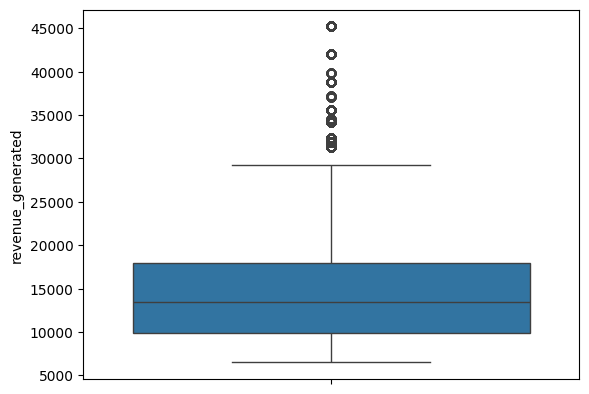

In [19]:
sns.boxplot(data_set['revenue_generated'])

<Axes: ylabel='no_days_book_to_checkin'>

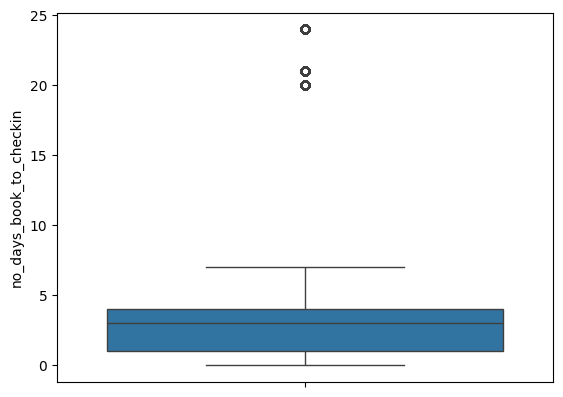

In [20]:
sns.boxplot(data_set['no_days_book_to_checkin'])

In [21]:
def iqr_method(outlier):
    #Removing Outliers using IQR Method
    q1=data_set[outlier].quantile(0.25)
    q3=data_set[outlier].quantile(0.75)
    iqr=q3-q1
    upper_limit = q3 + (1.5*iqr)
    lower_limit = q1 - (1.5*iqr)
    #capping
    data_set.loc[(data_set[outlier]>upper_limit),outlier]=upper_limit
    data_set.loc[(data_set[outlier]<lower_limit),outlier]=lower_limit

In [22]:
iqr_method('revenue_generated')
iqr_method('no_days_book_to_checkin')

C:\Users\donku\AppData\Local\Temp\ipykernel_12316\1941874273.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_set.loc[(data_set[outlier]>upper_limit),outlier]=upper_limit


<Axes: ylabel='no_days_book_to_checkin'>

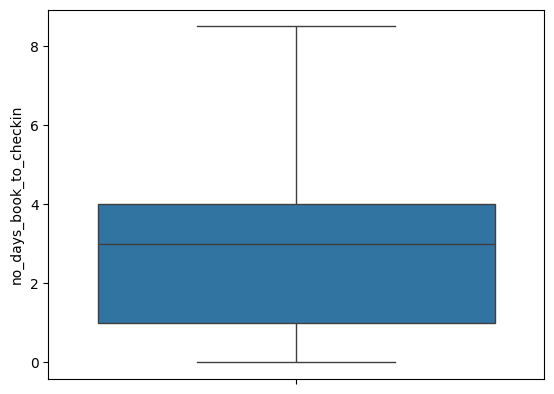

In [23]:
sns.boxplot(data_set['no_days_book_to_checkin'])

<Axes: ylabel='revenue_generated'>

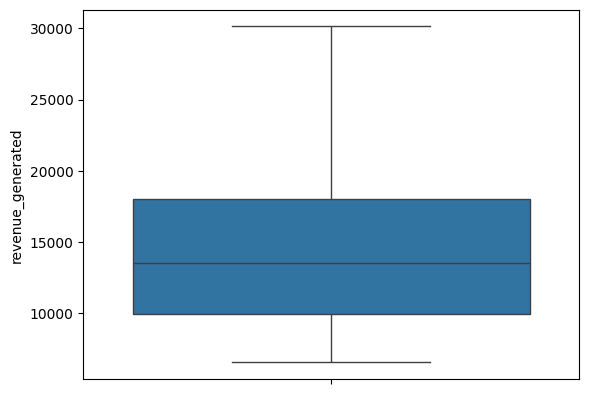

In [24]:
sns.boxplot(data_set['revenue_generated'])

In [25]:
data_set["rev_person"]=data_set["revenue_generated"]/data_set["no_guests"]

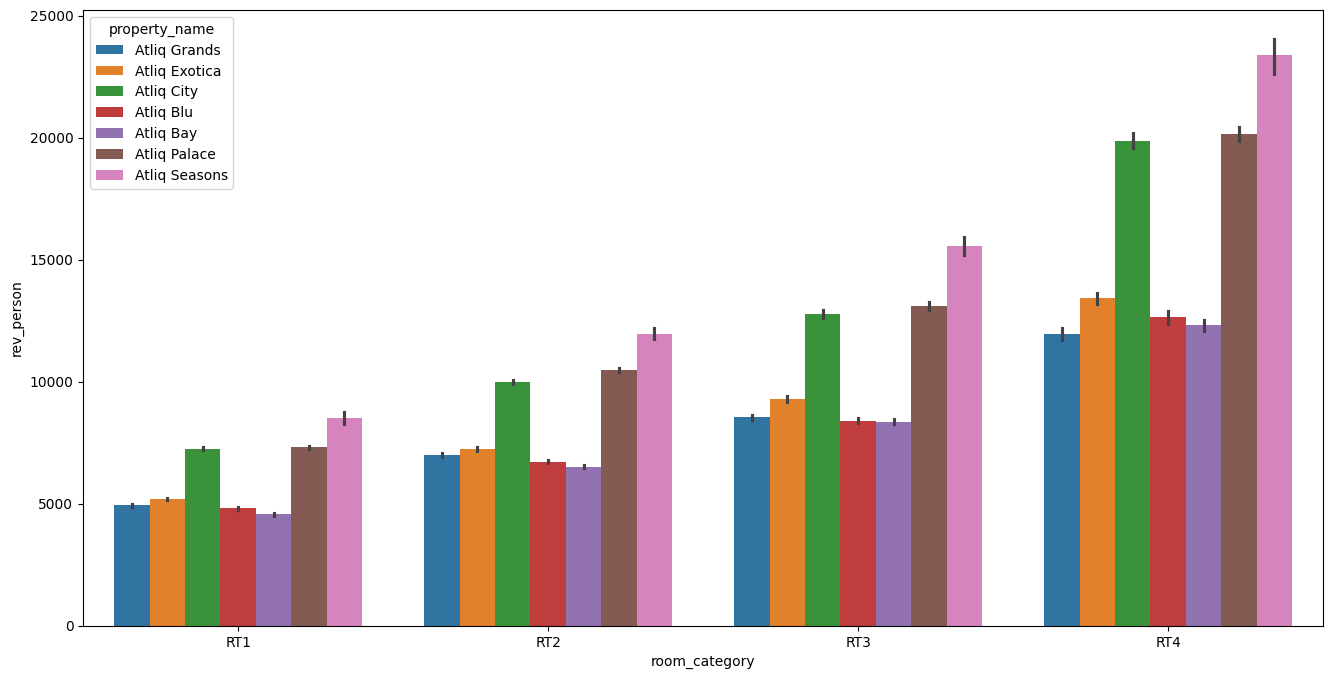

In [26]:
plt.figure(figsize=(16,8))
sns.barplot(data=data_set, x="room_category",y="rev_person",hue="property_name")
plt.show()

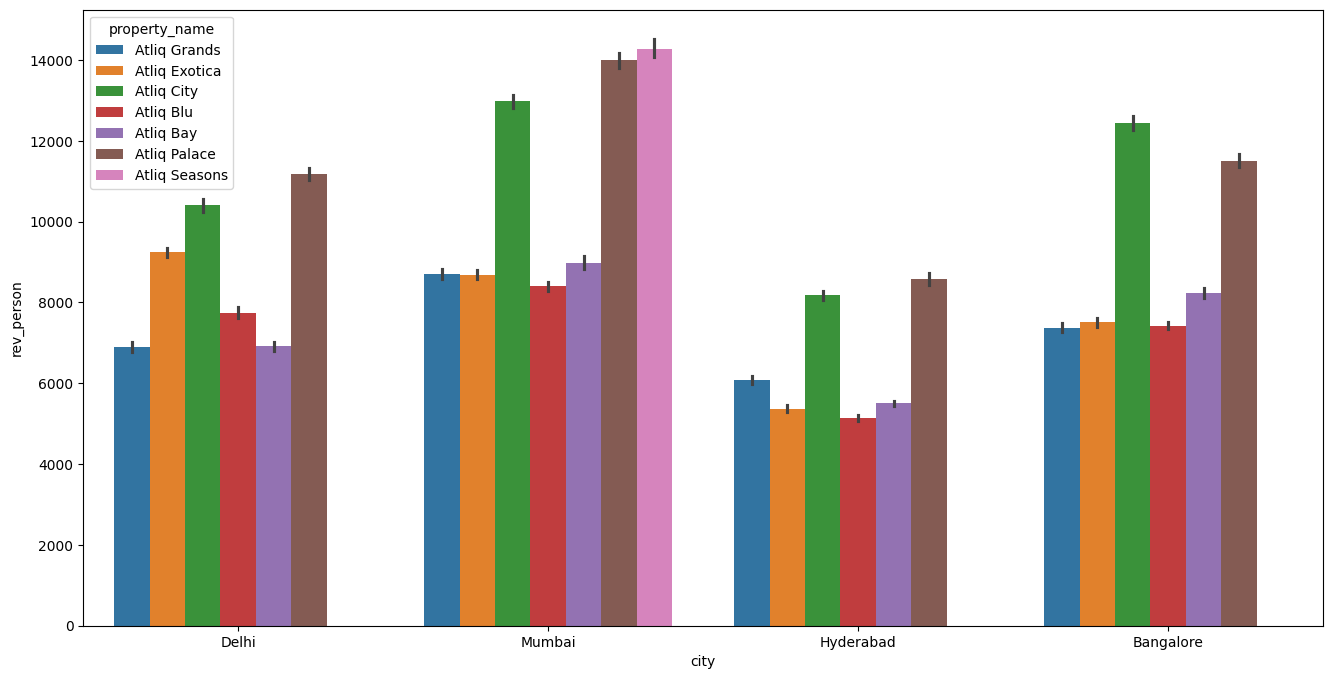

In [27]:
plt.figure(figsize=(16,8))
sns.barplot(data=data_set, x="city",y="rev_person",hue="property_name")
plt.show()

In [28]:
#Removal of Data which is done after feature generation
data_set=data_set.drop(columns=['booking_date','check_in_date','checkout_date'],axis=0)

<h5> Behaviour of booking_status based on input variables </h5>
<h5> Out of 134590 reservation, Checked Out - 94411, Cancelled -  33420 , No Show - 6579</h5>
<h5> The output variable is considered on the basis of room cancellation,</h5>
<h5> So a new columns has been created 'is_cancelled' which considers Cancelled and No Show as 1 while the Checked Out as 0  </h5>
<h5> Out of the seven hotels, Atliq Season charges more for their rooms compared to others. </h5>
<h5> Most reservation are booked for two guests and the room category (RT2) </h5>
<h5> Most of the reservation are reserved through other means </h5>
<h5> Luxury type hotels are reserved more than the Business ones </h5>
<h5> Most people reserve their rooms for one day and book them within three days before the check-in date </h5>

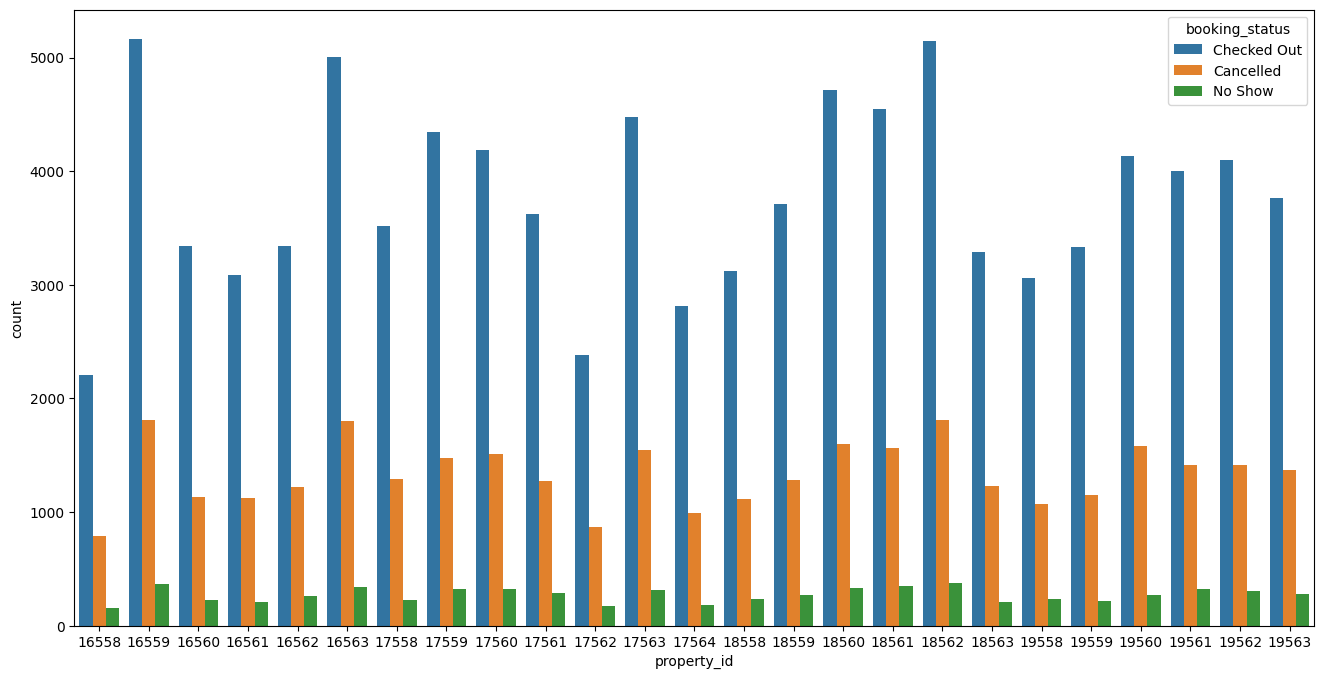

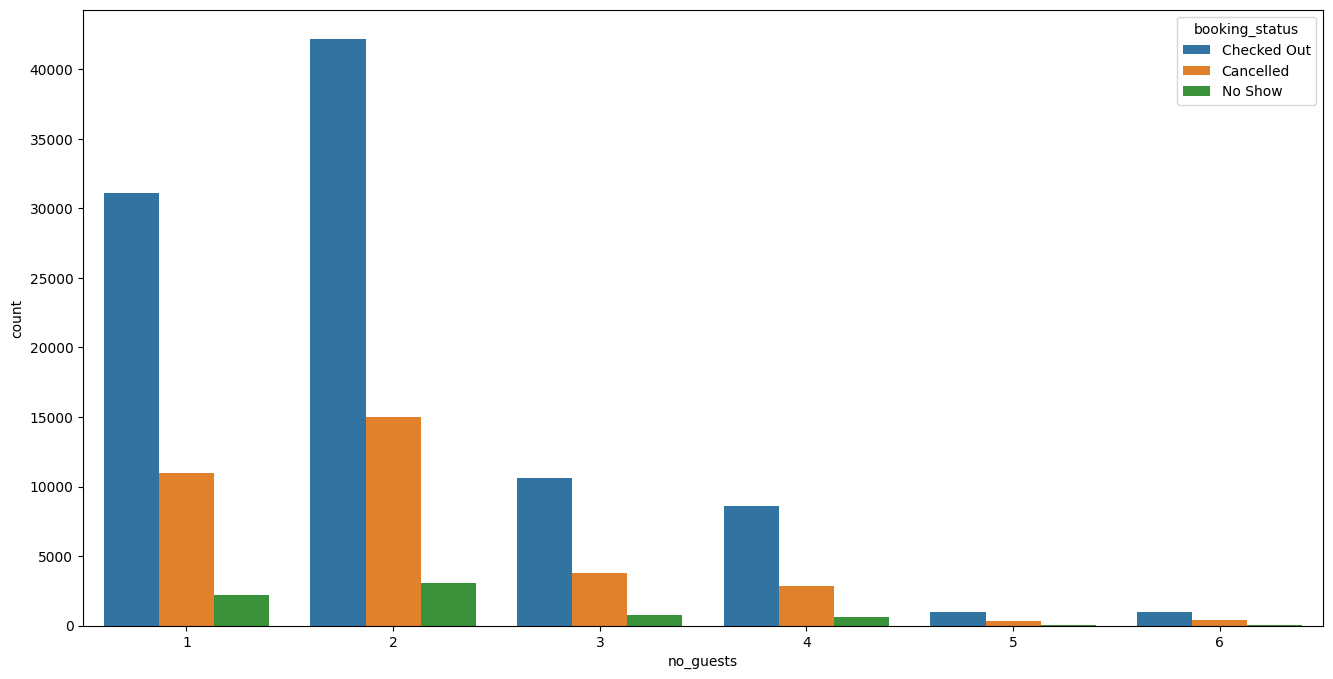

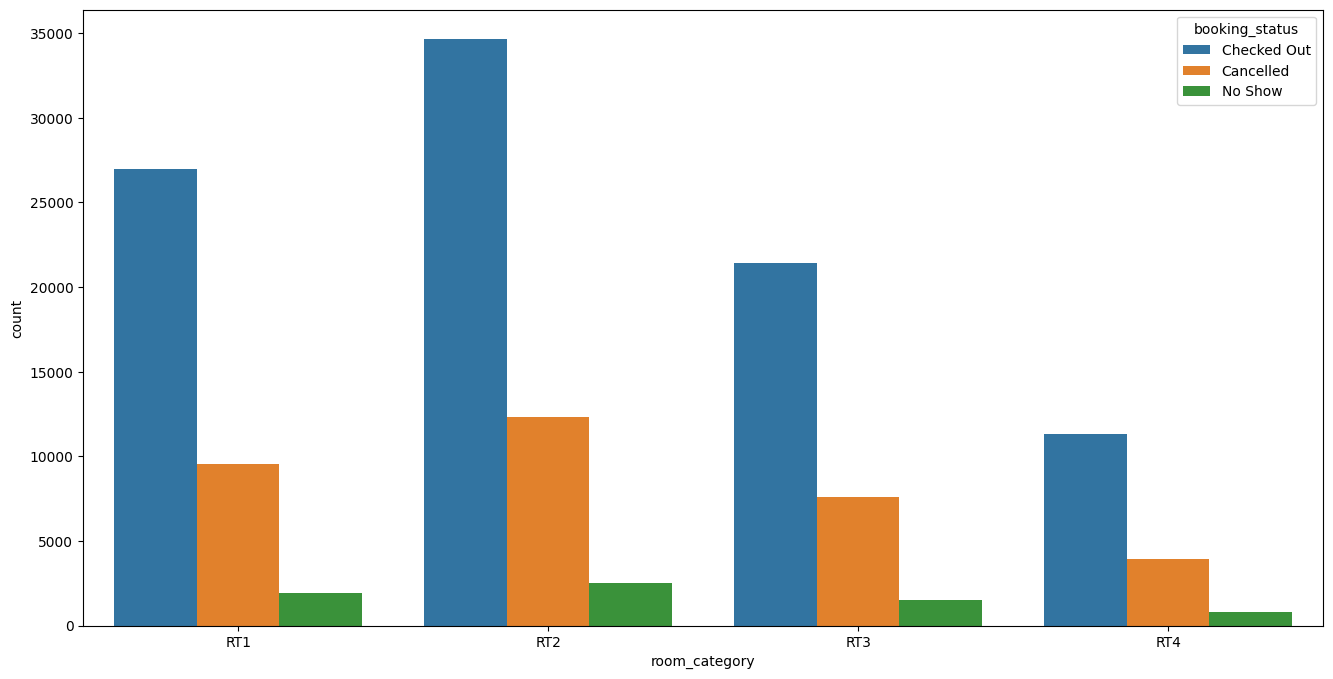

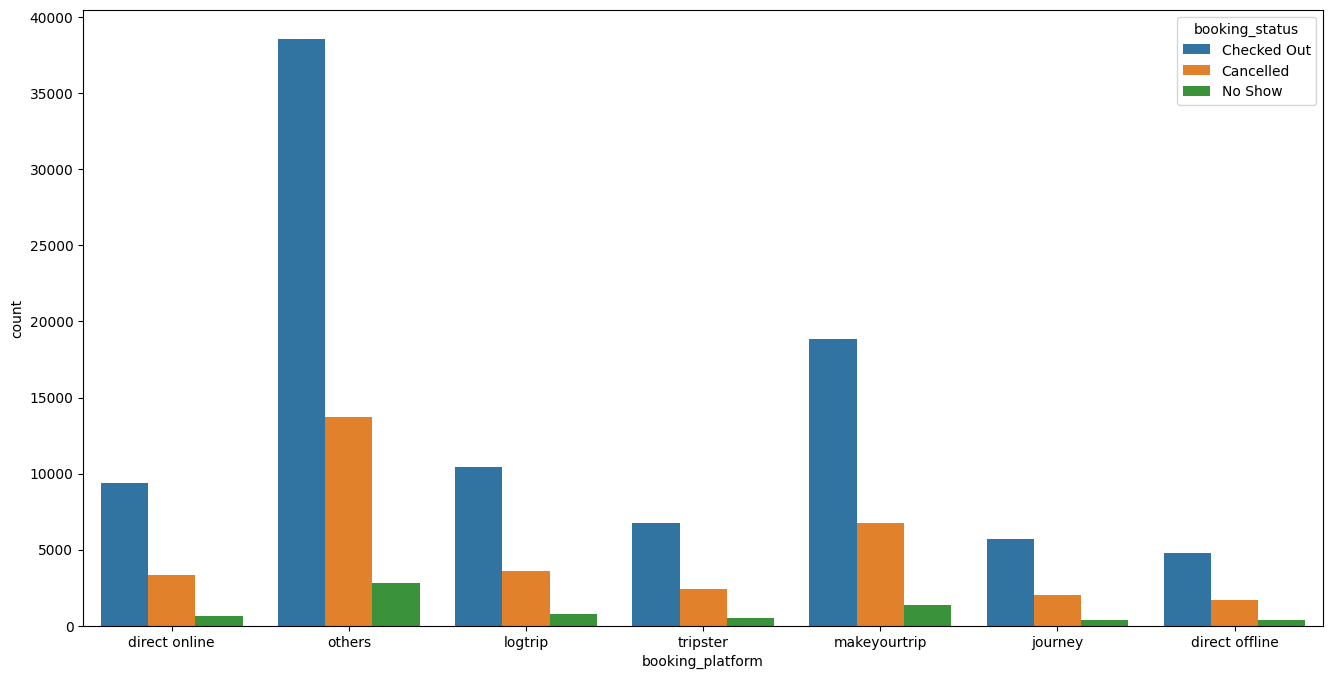

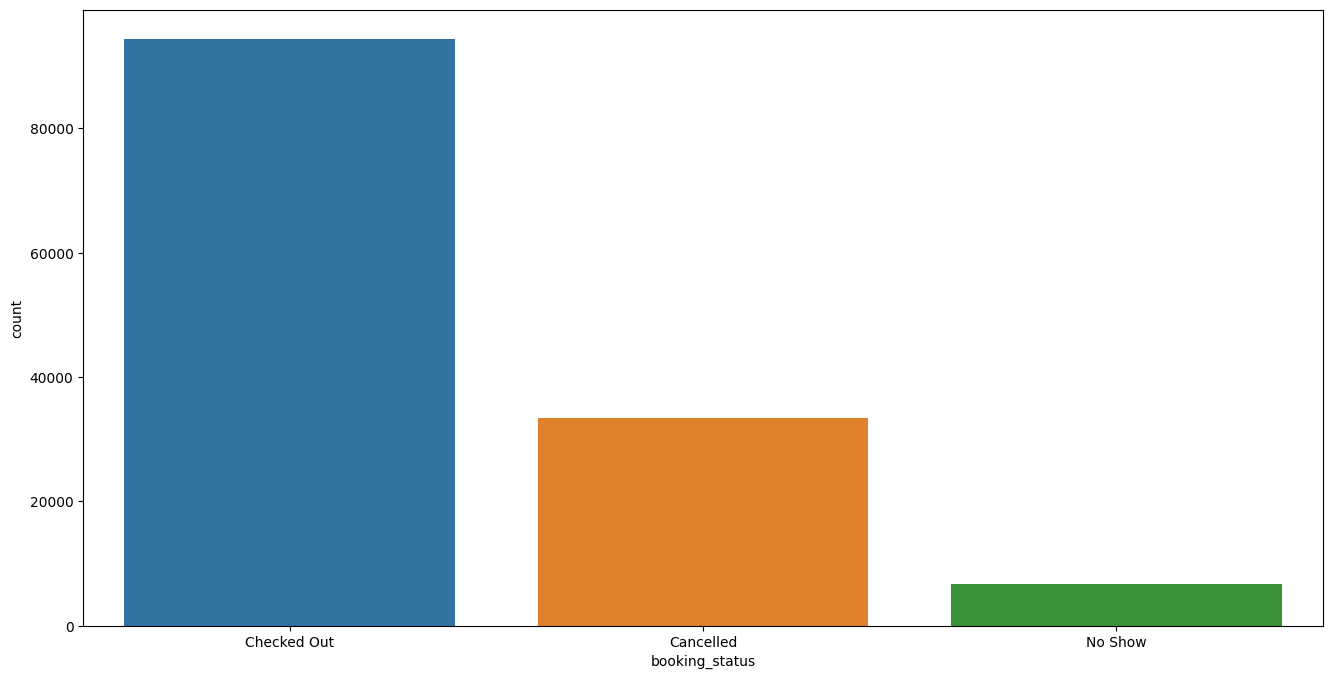

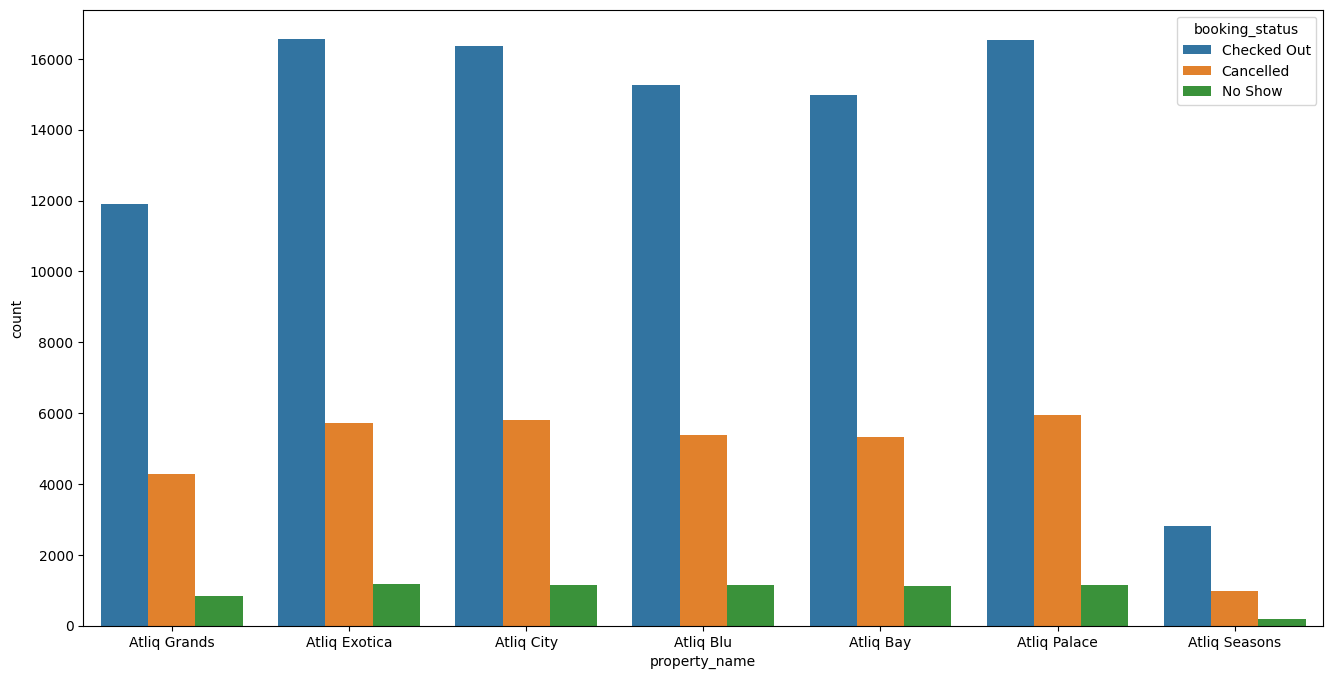

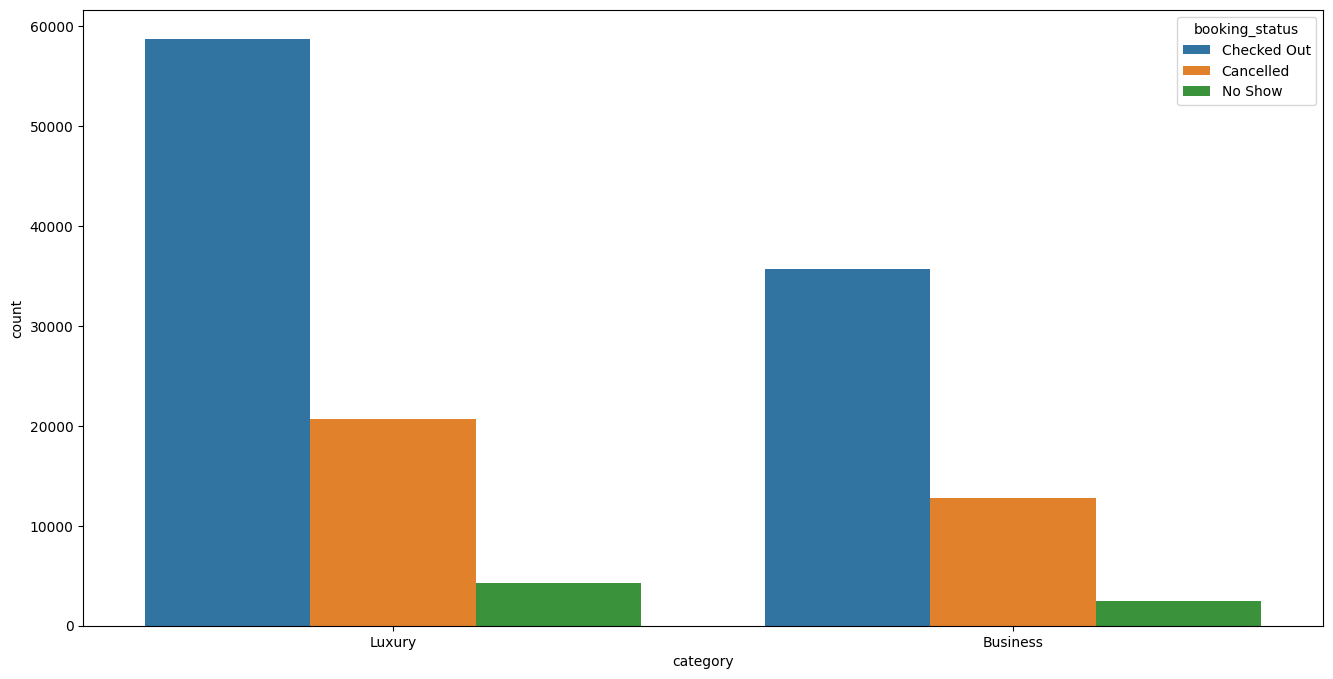

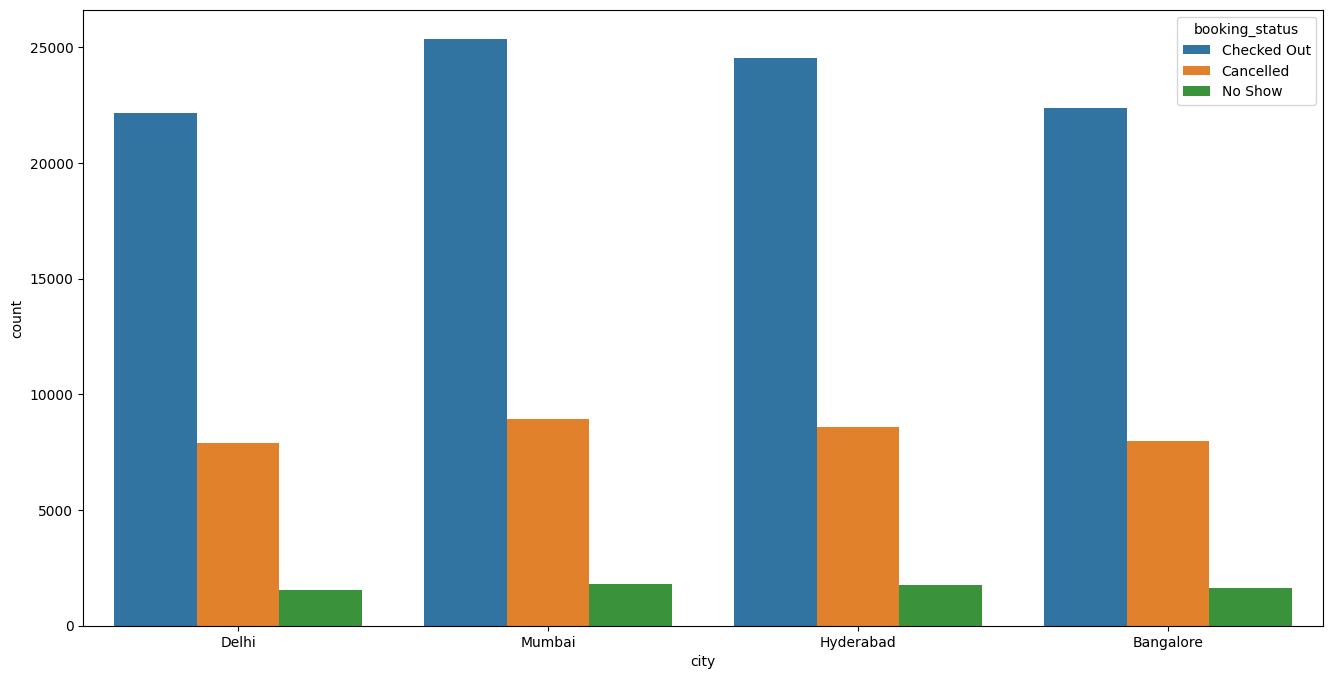

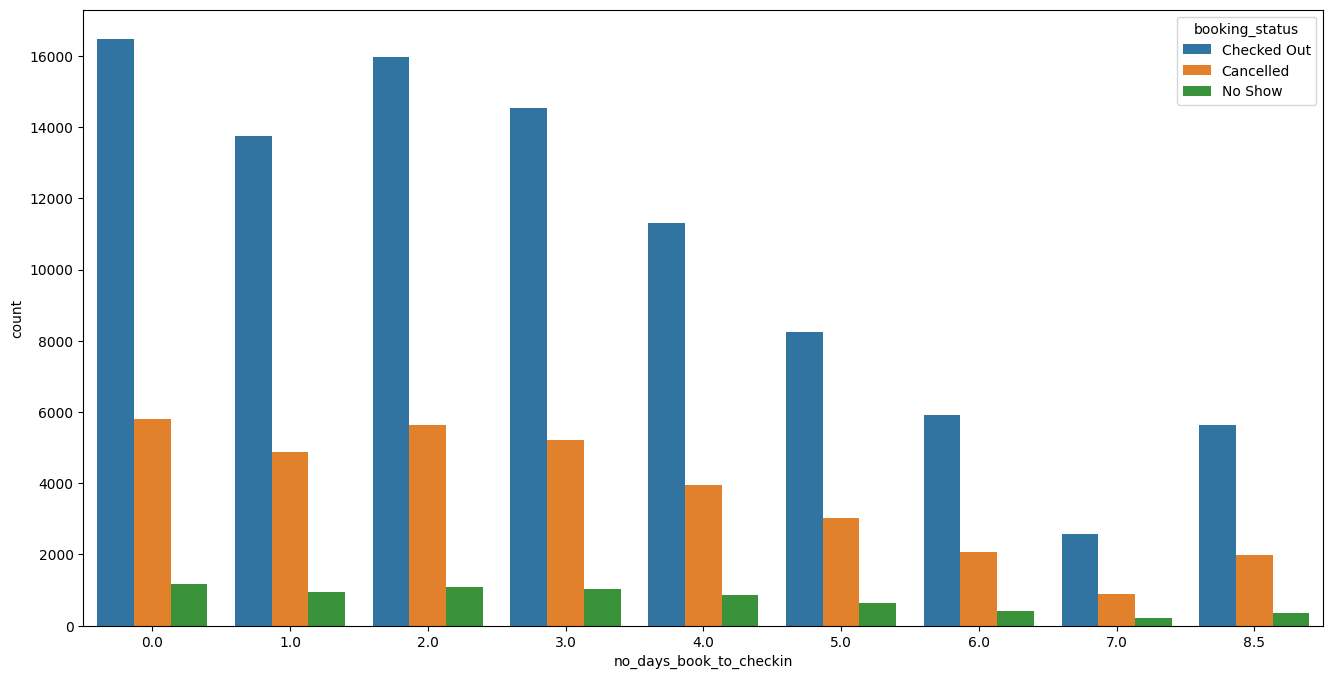

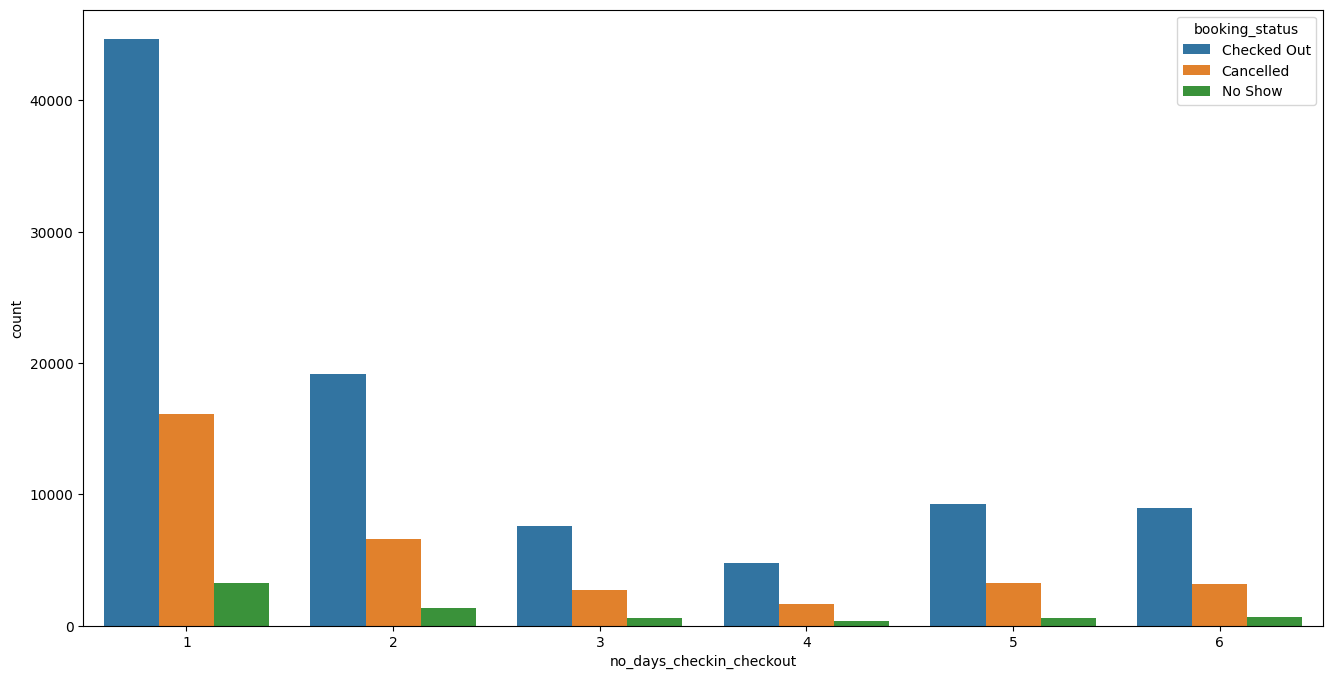

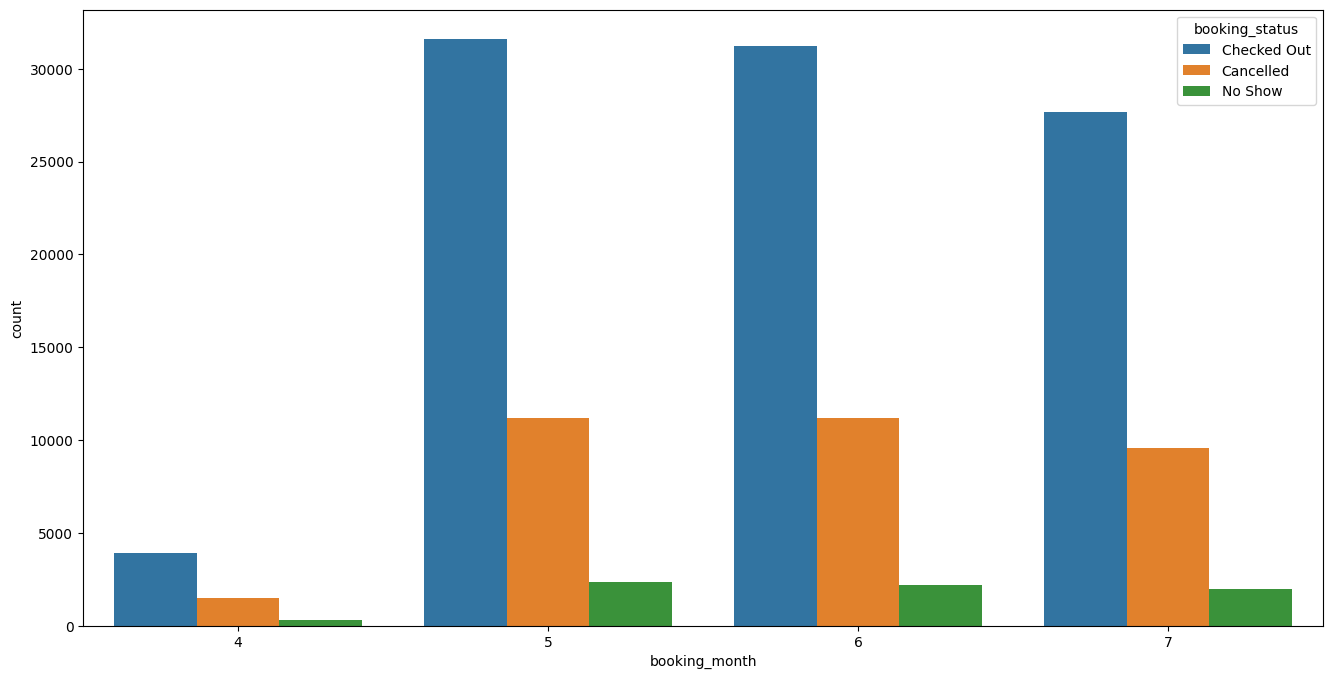

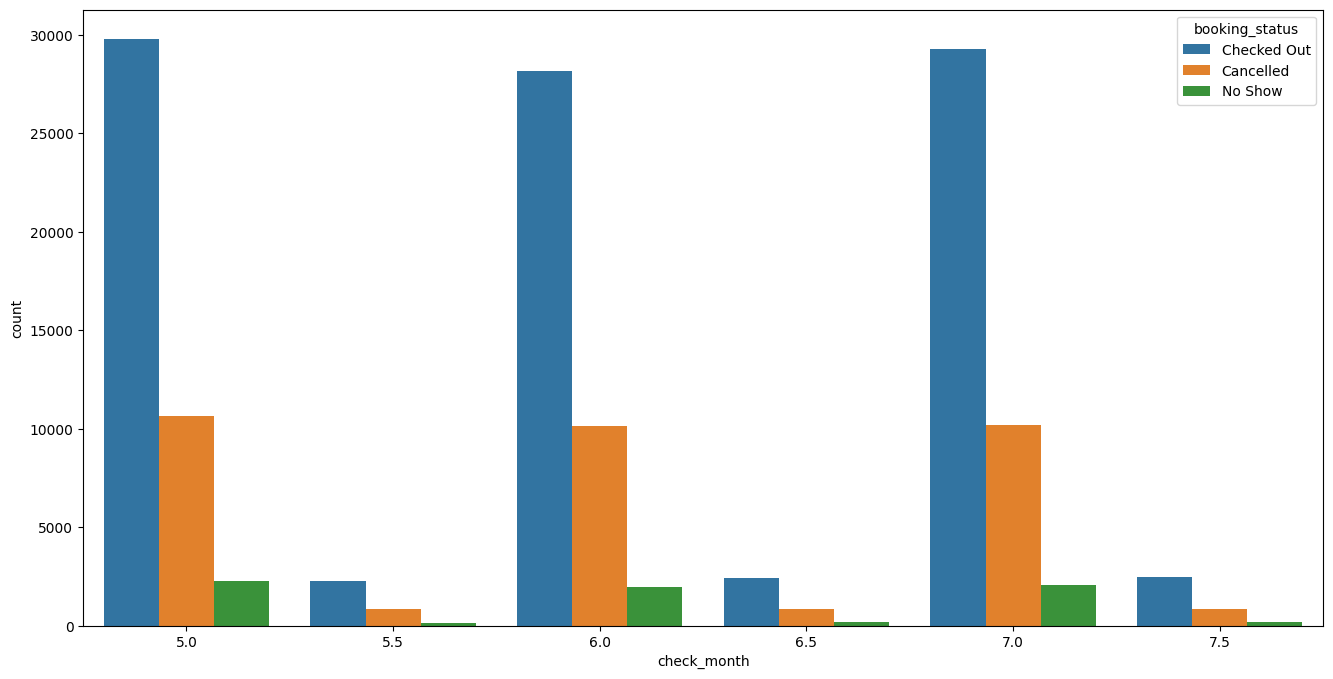

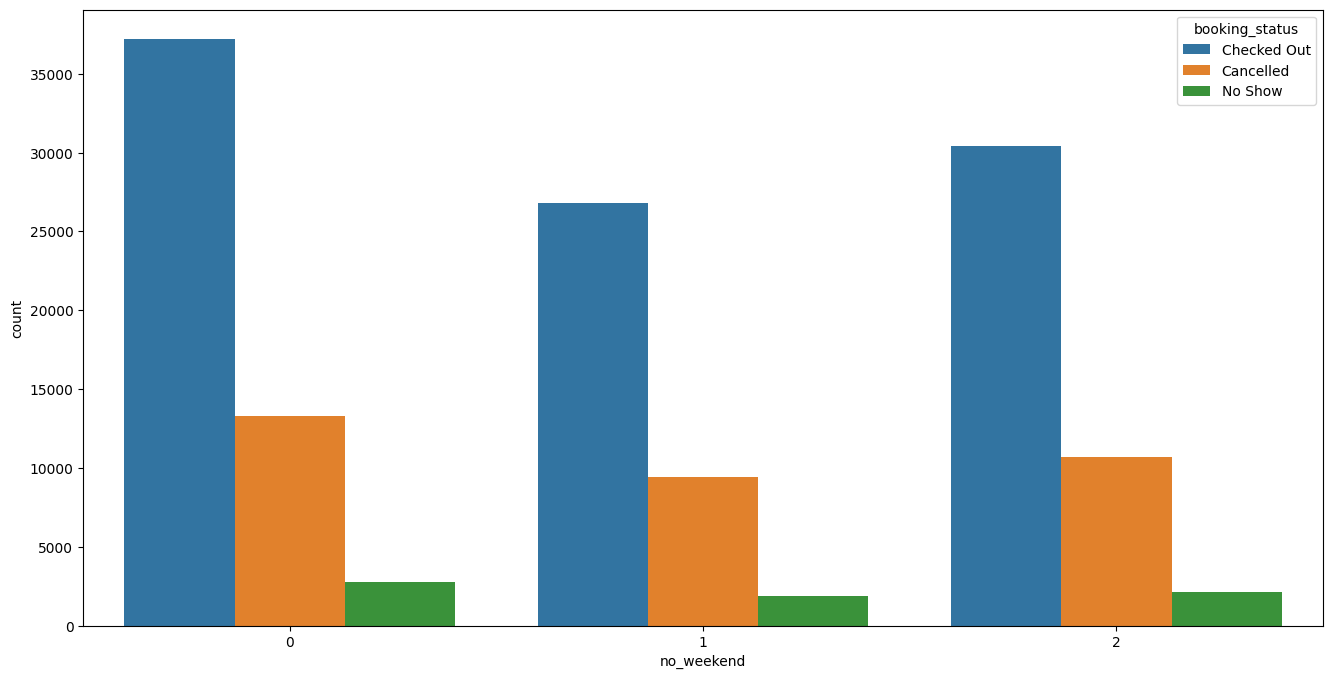

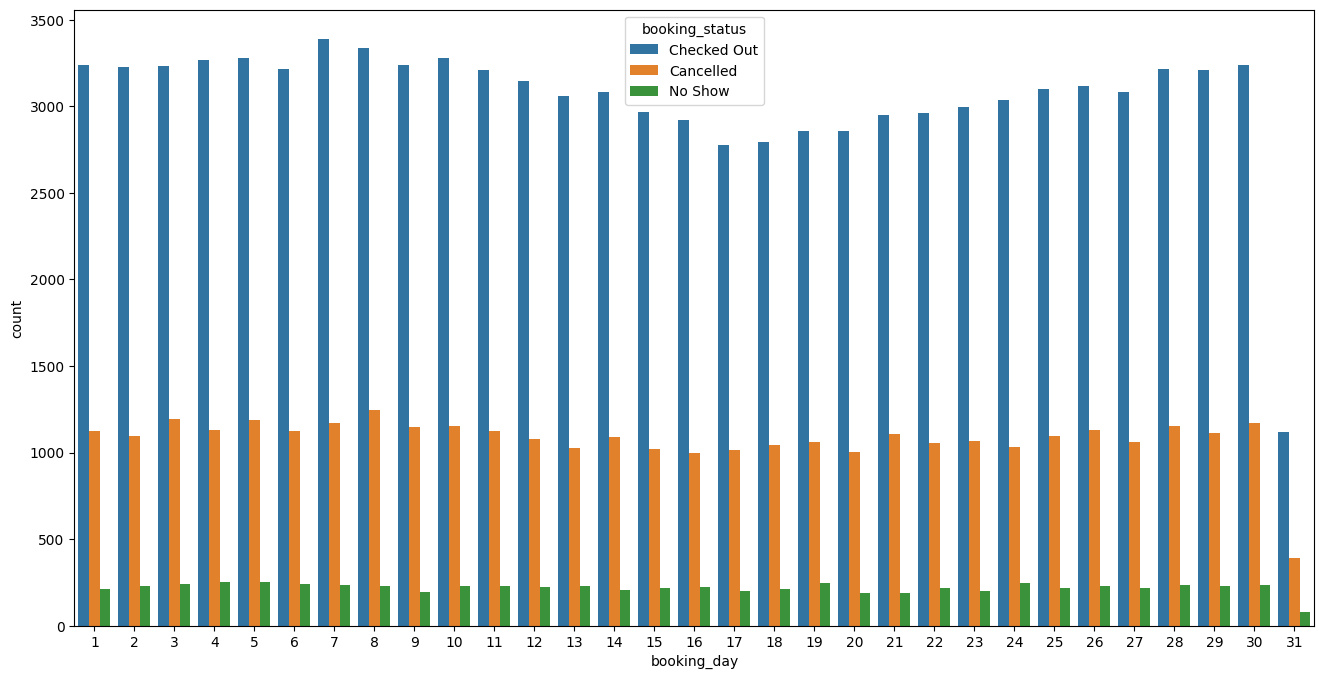

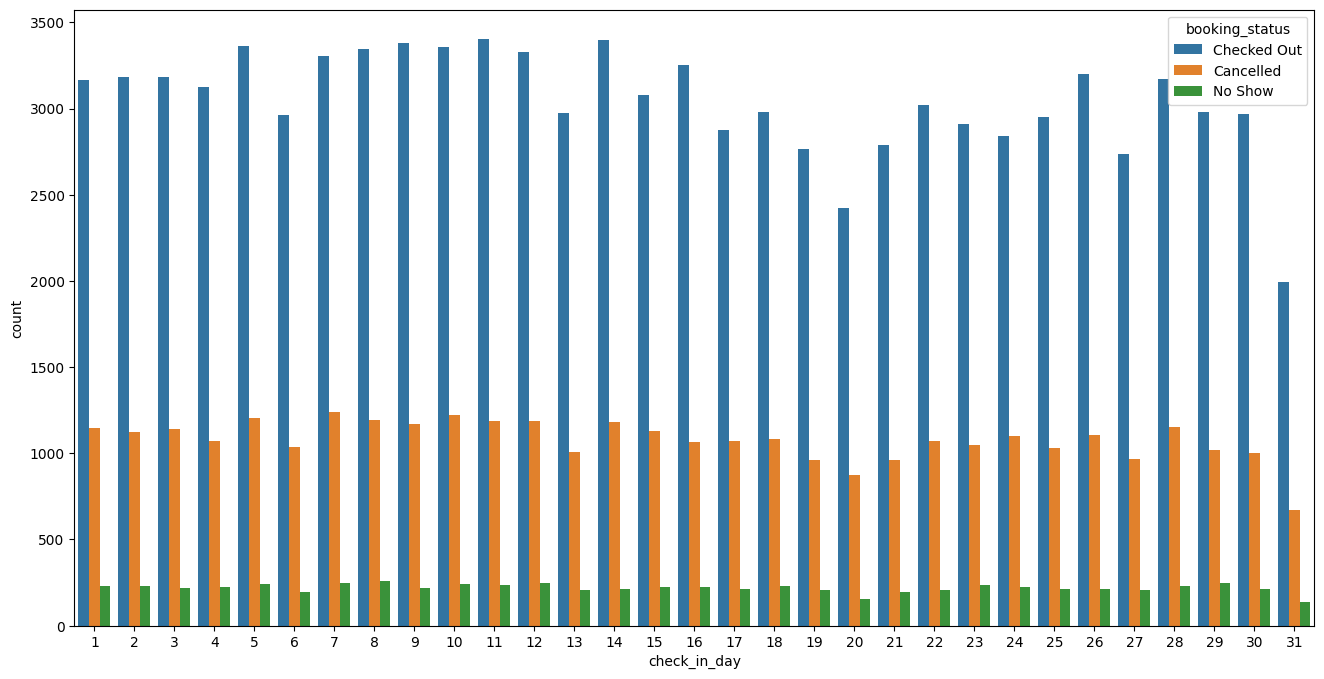

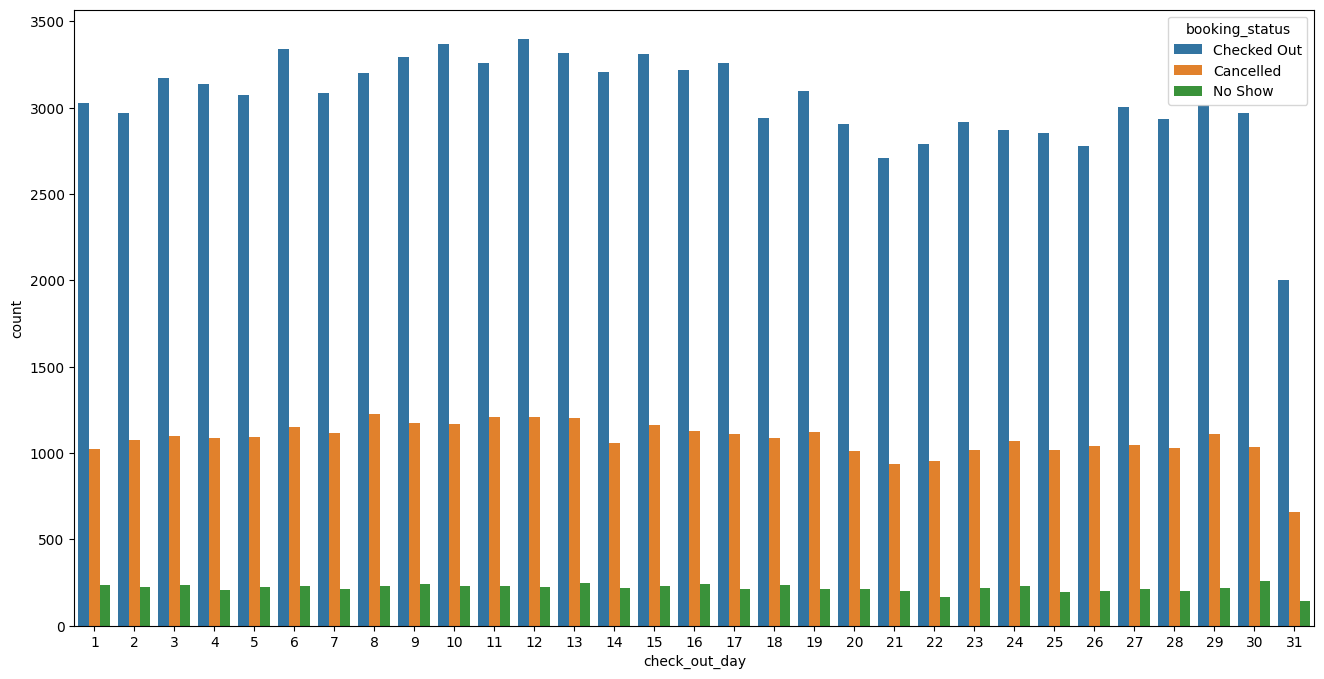

In [29]:
for column in data_set.columns:
    if (column!='revenue_generated' and column!='rev_person'):
        plt.figure(figsize=(16,8))
        sns.countplot(data_set,x=column,hue='booking_status')
        plt.show()

<Axes: ylabel='count'>

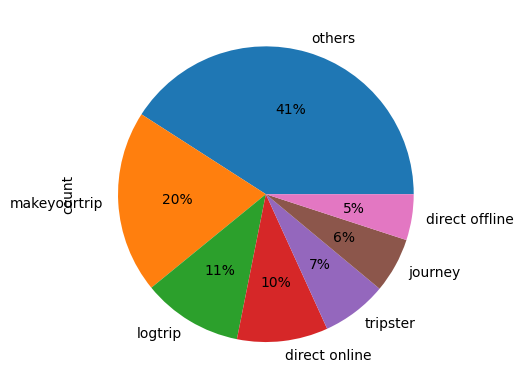

In [30]:
data_set.booking_platform.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

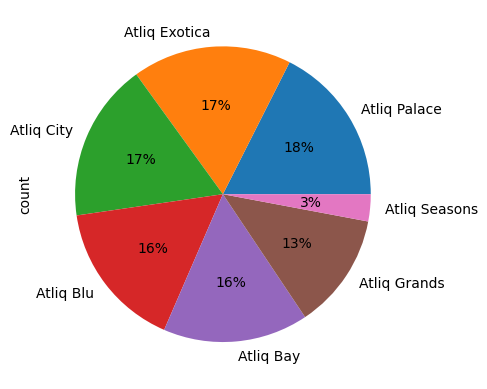

In [31]:
data_set.property_name.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

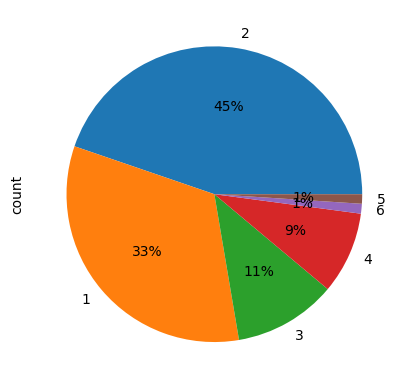

In [32]:
data_set.no_guests.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

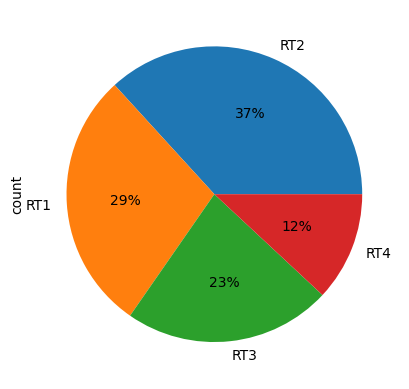

In [33]:
data_set.room_category.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

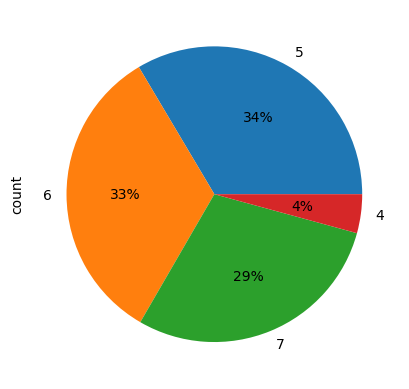

In [34]:
data_set.booking_month.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

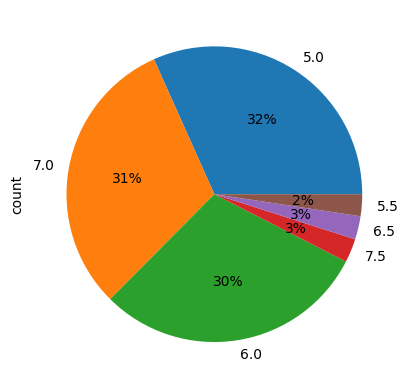

In [35]:
data_set.check_month.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

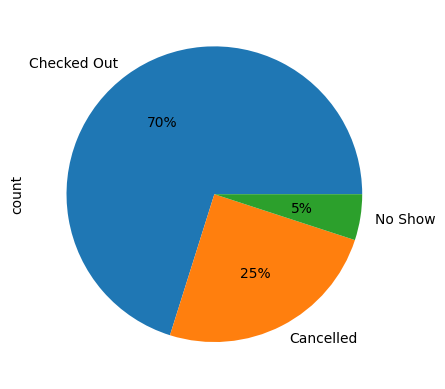

In [36]:
data_set.booking_status.value_counts().plot(kind='pie',autopct='%1.0f%%')

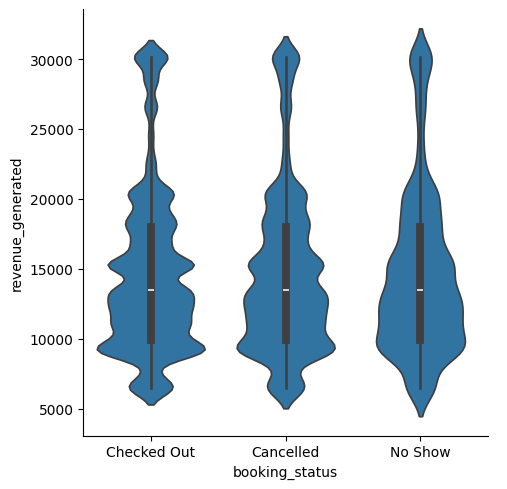

In [37]:
sns.catplot(y= 'revenue_generated', x = 'booking_status', data = data_set, kind = 'violin')

<h1>Splitting the dataset into input and output set</h1>

In [38]:
data_set["booking_status"]=data_set["booking_status"].map({'Checked Out':1,'No Show':0,'Cancelled':0})

In [39]:
#Feature Selection
data_set_X=data_set.drop(columns='booking_status')
data_set_Y=data_set['booking_status']

In [40]:
data_set_X.head()

,property_id,no_guests,room_category,booking_platform,revenue_generated,property_name,category,city,no_days_book_to_checkin,no_days_checkin_checkout,rev_person,booking_month,check_month,no_weekend,booking_day,check_in_day,check_out_day
0,16558,3,RT1,direct online,10010,Atliq Grands,Luxury,Delhi,4.0,1,3336.666667,4,5.0,0,27,1,2
1,16558,2,RT1,others,9100,Atliq Grands,Luxury,Delhi,1.0,1,4550.000000,4,5.0,0,30,1,2
2,16558,2,RT1,logtrip,9100,Atliq Grands,Luxury,Delhi,3.0,3,4550.000000,4,5.0,0,28,1,4
3,16558,2,RT1,others,9100,Atliq Grands,Luxury,Delhi,3.0,1,4550.000000,4,5.0,0,28,1,2
4,16558,4,RT1,direct online,10920,Atliq Grands,Luxury,Delhi,4.0,1,2730.000000,4,5.0,0,27,1,2


In [41]:
data_set_X=data_set_X.drop(columns=['property_id','booking_platform','revenue_generated','rev_person'])

# Splitting Data

In [42]:
train_X_raw,test_X_raw,train_Y,test_Y=train_test_split(data_set_X,data_set_Y,train_size=0.7,random_state=42,stratify=data_set_Y)
val_X_raw,test_X_raw,val_Y,test_Y=train_test_split(test_X_raw,test_Y,train_size=0.5,random_state=42,stratify=test_Y)

# Encoding Categorical Variables

In [43]:
encoder = ce.OneHotEncoder()
train_X_encoded=encoder.fit_transform(train_X_raw,train_Y)
val_X_encoded=encoder.transform(val_X_raw)
test_X_encoded=encoder.transform(test_X_raw)

# Scaling Numerical Features:

In [44]:
data_set_X.head()

,no_guests,room_category,property_name,category,city,no_days_book_to_checkin,no_days_checkin_checkout,booking_month,check_month,no_weekend,booking_day,check_in_day,check_out_day
0,3,RT1,Atliq Grands,Luxury,Delhi,4.0,1,4,5.0,0,27,1,2
1,2,RT1,Atliq Grands,Luxury,Delhi,1.0,1,4,5.0,0,30,1,2
2,2,RT1,Atliq Grands,Luxury,Delhi,3.0,3,4,5.0,0,28,1,4
3,2,RT1,Atliq Grands,Luxury,Delhi,3.0,1,4,5.0,0,28,1,2
4,4,RT1,Atliq Grands,Luxury,Delhi,4.0,1,4,5.0,0,27,1,2


# Oversampling

In [45]:
smote=SMOTE(random_state=0)
train_X_SMOTE,train_Y_SMOTE=smote.fit_resample(train_X_encoded,train_Y)

<h1>Feature Selection</h1>

In [46]:
train_X_SMOTE

,no_guests,room_category_1,room_category_2,room_category_3,room_category_4,property_name_1,property_name_2,property_name_3,property_name_4,property_name_5,...,city_3,city_4,no_days_book_to_checkin,no_days_checkin_checkout,booking_month,check_month,no_weekend,booking_day,check_in_day,check_out_day
0,2,1,0,0,0,1,0,0,0,0,...,0,0,3.000000,2,6,6.0,1,8,11,13
1,1,0,1,0,0,0,1,0,0,0,...,0,0,0.000000,1,7,7.0,0,19,19,20
2,2,0,1,0,0,0,0,1,0,0,...,1,0,3.000000,3,6,6.0,1,4,7,10
3,1,0,1,0,0,0,1,0,0,0,...,1,0,3.000000,1,5,6.0,0,29,1,2
4,1,0,1,0,0,1,0,0,0,0,...,0,1,3.000000,1,6,6.0,0,2,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132171,2,0,0,0,1,0,0,0,0,0,...,0,0,4.000000,1,5,5.0,0,7,11,12
132172,2,0,0,0,1,0,0,0,0,0,...,0,0,3.619914,4,6,6.0,0,22,26,30
132173,2,0,0,0,0,1,0,0,0,0,...,0,0,2.000000,1,6,6.0,0,13,15,16
132174,2,0,1,0,0,0,0,0,0,0,...,0,0,1.000000,1,5,5.0,0,3,4,5


<Axes: >

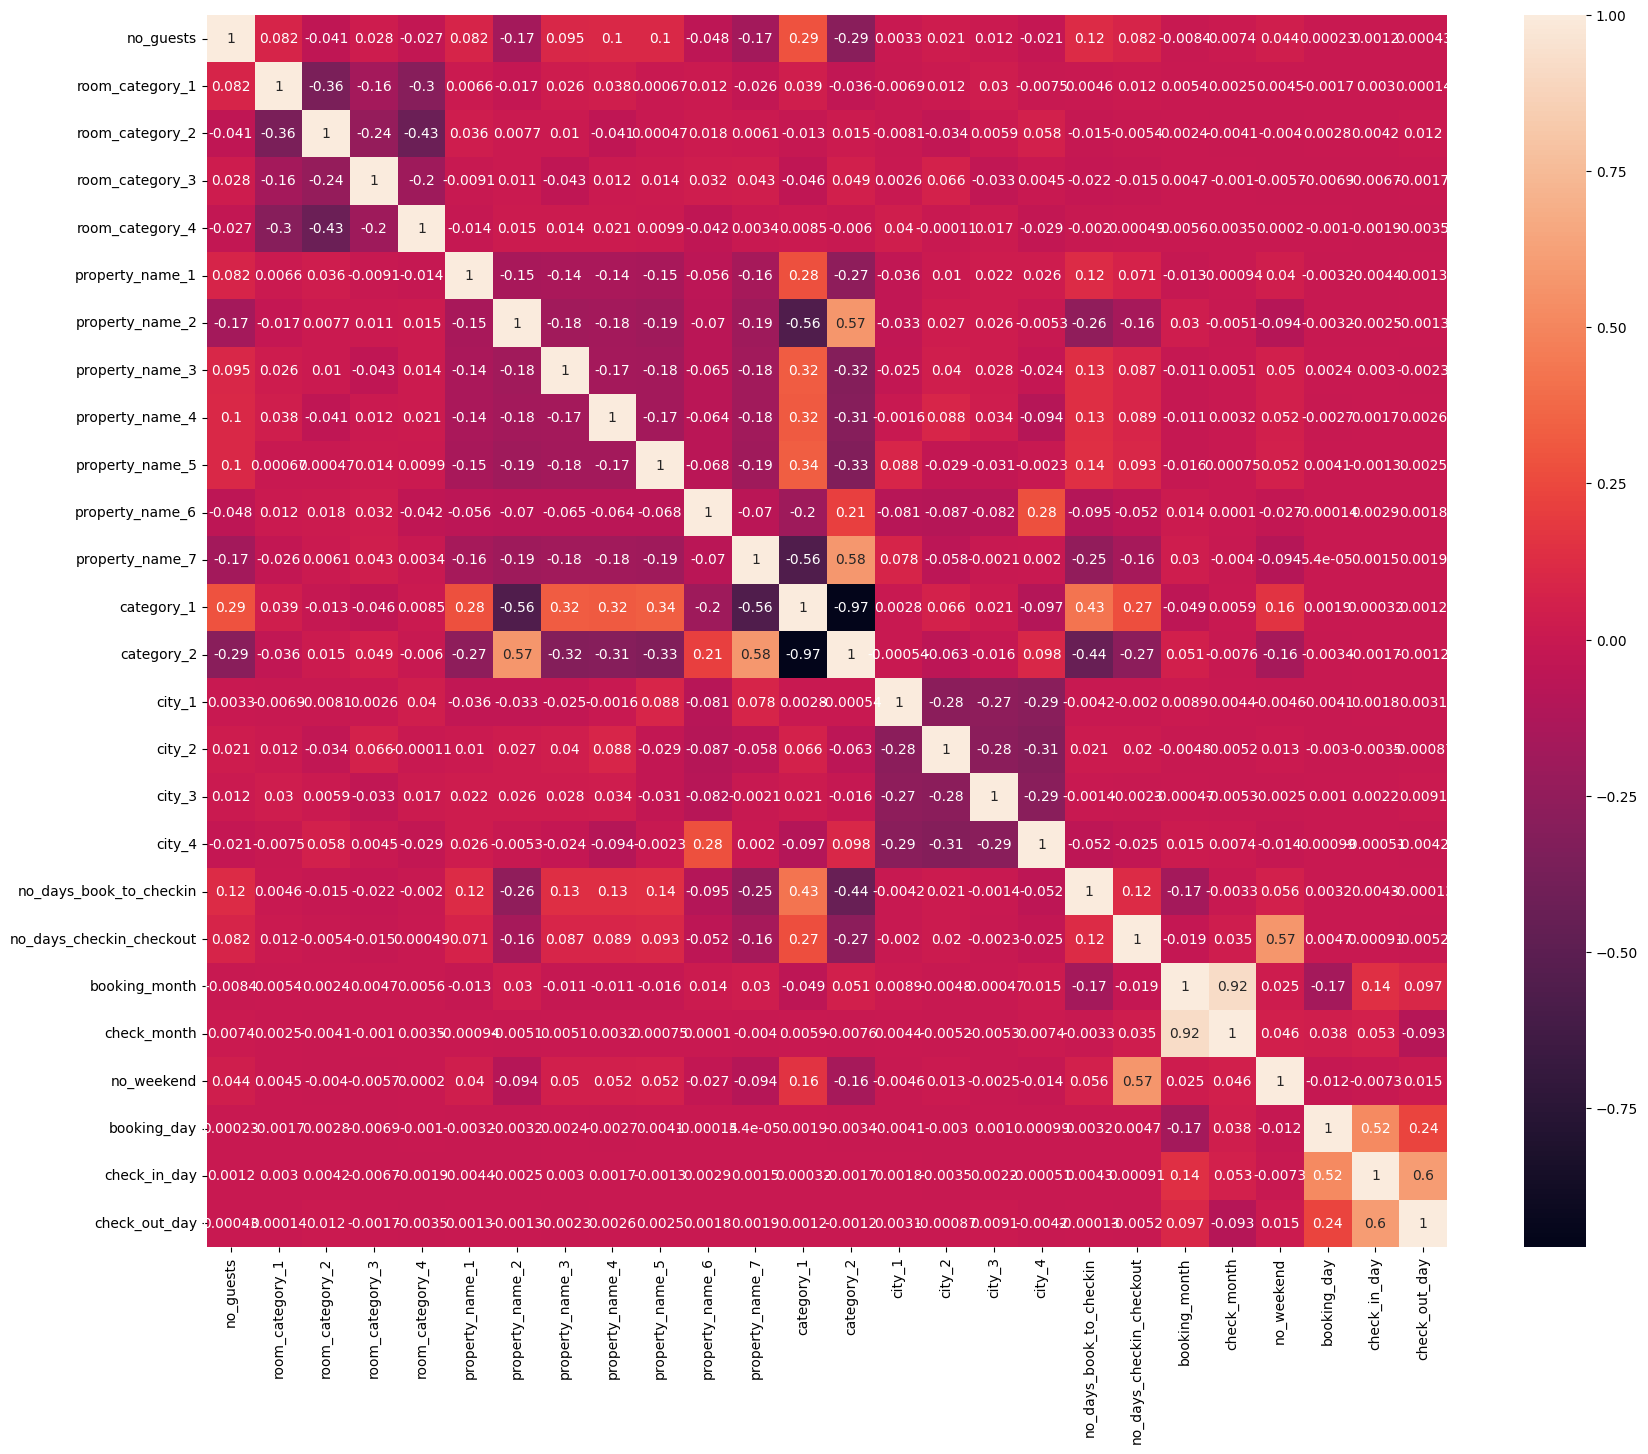

In [47]:
corelation = train_X_SMOTE.corr()
plt.figure(figsize=(20,16))
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns,annot=True)

In [48]:
def correlation(dataset,threshold):
    col_corr=set()
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>=threshold:
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [49]:
corr_features=correlation(train_X_SMOTE,0.7)
train_X_corr=train_X_SMOTE.drop(corr_features,axis=1)
val_X_corr=val_X_encoded.drop(corr_features,axis=1)
test_X_corr=test_X_encoded.drop(corr_features,axis=1)
corr_features

{'category_2', 'check_month'}

In [50]:
train_X_corr.head()

,no_guests,room_category_1,room_category_2,room_category_3,room_category_4,property_name_1,property_name_2,property_name_3,property_name_4,property_name_5,...,city_2,city_3,city_4,no_days_book_to_checkin,no_days_checkin_checkout,booking_month,no_weekend,booking_day,check_in_day,check_out_day
0,2,1,0,0,0,1,0,0,0,0,...,0,0,0,3.0,2,6,1,8,11,13
1,1,0,1,0,0,0,1,0,0,0,...,1,0,0,0.0,1,7,0,19,19,20
2,2,0,1,0,0,0,0,1,0,0,...,0,1,0,3.0,3,6,1,4,7,10
3,1,0,1,0,0,0,1,0,0,0,...,0,1,0,3.0,1,5,0,29,1,2
4,1,0,1,0,0,1,0,0,0,0,...,0,0,1,3.0,1,6,0,2,5,6


In [51]:
train_X_corr.shape

(132176, 24)

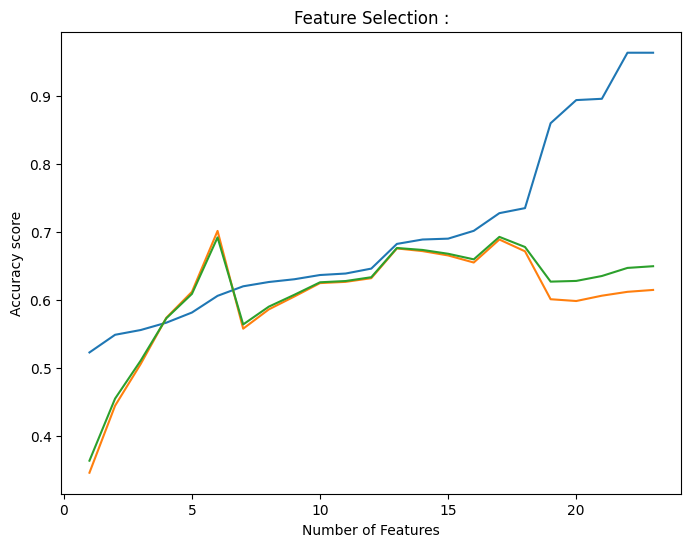

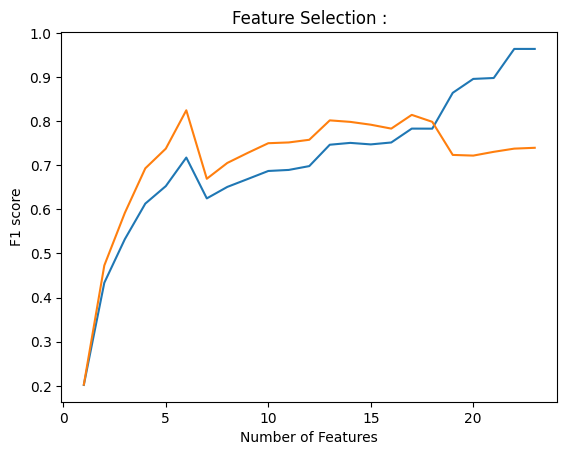

In [52]:
train_acc = {}
test_acc = {}
train_f1 = {}
test_f1 = {}
acc_per_features = {}
variable = np.arange(1,24)
for i in variable:
    sel_five_cols=SelectKBest(chi2, k=i)
    sel_five_cols.fit(train_X_corr,train_Y_SMOTE)
    train_X_chi=train_X_corr[train_X_corr.columns[sel_five_cols.get_support()]]
    test_X_chi=test_X_corr[test_X_corr.columns[sel_five_cols.get_support()]]
    model= RandomForestClassifier()
    model.fit(train_X_chi,train_Y_SMOTE)
    pred_train_Y = model.predict(train_X_chi)
    pred_Y = model.predict(test_X_chi)
    train_acc[i-1]=accuracy_score(pred_train_Y,train_Y_SMOTE)
    test_acc[i-1]=accuracy_score(pred_Y,test_Y)
    acc_per_features[i-1]=(0.1*train_acc[i-1])+(0.9*test_acc[i-1])
    train_f1[i-1]=f1_score(pred_train_Y,train_Y_SMOTE)
    test_f1[i-1]=f1_score(pred_Y,test_Y)
plt.figure(figsize=(8,6))
plt.title("Feature Selection :")
plt.plot(variable, train_acc.values(), label="Training Accuracy score")
plt.plot(variable, test_acc.values(), label="Testing Accuracy score")
plt.plot(variable, acc_per_features.values(), label="Selection Accuracy score")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy score")
plt.show()
plt.title("Feature Selection :")
plt.plot(variable, train_f1.values(), label="Training F1 score")
plt.plot(variable, test_f1.values(), label="Testing F1 score")
plt.xlabel("Number of Features")
plt.ylabel("F1 score")
plt.show()

In [53]:
print(acc_per_features)
acc_value=[]
for i in variable:
  acc_value.append(acc_per_features[i-1])
max_acc_chi=max(acc_value)
sel_features_chi=acc_value.index(max_acc_chi)
print("The number of features which are selected for training the model are ",sel_features_chi, "which gives an accuracy of ",max_acc_chi)

{0: 0.36356978862574, 1: 0.45487875781647, 2: 0.5107678078281773, 3: 0.5730079347266144, 4: 0.6088731127166519, 5: 0.6919250051365162, 6: 0.5639609595852902, 7: 0.5900909705920979, 8: 0.6076162363399203, 9: 0.6259351340520857, 10: 0.6278031949622491, 11: 0.6333863112608966, 12: 0.6763823654684993, 13: 0.6735059973724637, 14: 0.6678832008977457, 15: 0.6596708926647898, 16: 0.6927169735828163, 17: 0.6778543402631119, 18: 0.6269067009892937, 19: 0.6279447969187846, 20: 0.6351788912999369, 21: 0.6470805028631234, 22: 0.6495753986646791}
The number of features which are selected for training the model are  16 which gives an accuracy of  0.6927169735828163


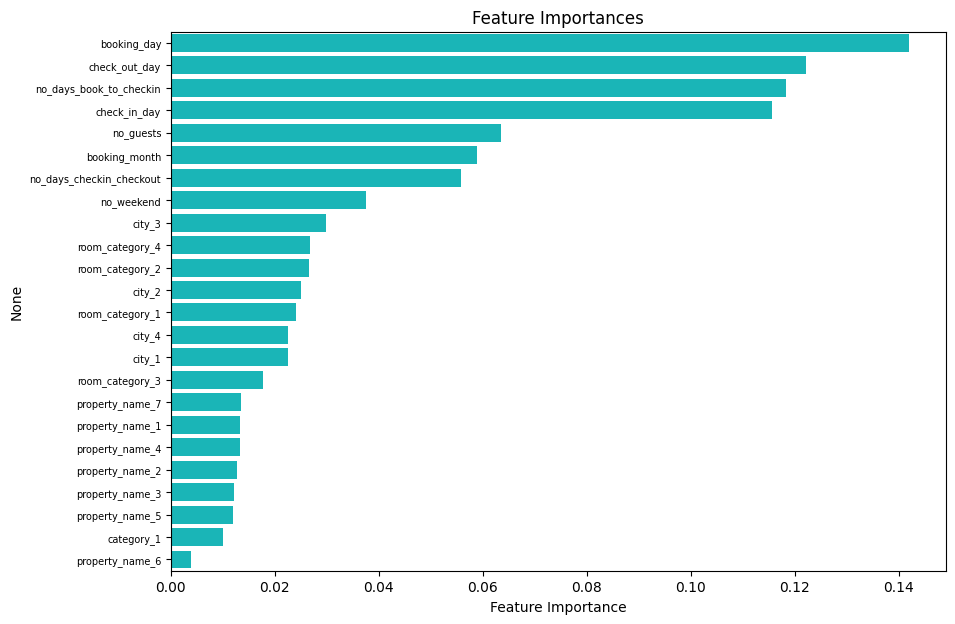

In [54]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
rdc=RandomForestClassifier(random_state=0, n_jobs=-1)
rdc.fit(train_X_corr,train_Y_SMOTE)
feature_importances = rdc.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importances[sorted_indices], y=train_X_corr.columns[sorted_indices], color='darkturquoise')
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.yticks(fontsize=7)
plt.show()

In [55]:
train_acc = {}
test_acc = {}
train_f1 = {}
test_f1 = {}
acc_per_features = {}
for i in range (2,len(sorted_indices)):
    train_X_rfc = train_X_corr.iloc[:, sorted_indices[0:i]]
    test_X_rfc = test_X_corr.iloc[:, sorted_indices[0:i]]
    model = RandomForestClassifier()
    model.fit(train_X_rfc,train_Y_SMOTE)
    pred_train_Y = model.predict(train_X_rfc)
    pred_Y = model.predict(test_X_rfc)
    train_acc[i-1]=accuracy_score(pred_train_Y,train_Y_SMOTE)
    test_acc[i-1]=accuracy_score(pred_Y,test_Y)
    acc_per_features[i-1]=(0.1*train_acc[i-1])+(0.9*test_acc[i-1])
    train_f1[i-1]=f1_score(pred_train_Y,train_Y_SMOTE)
    test_f1[i-1]=f1_score(pred_Y,test_Y)

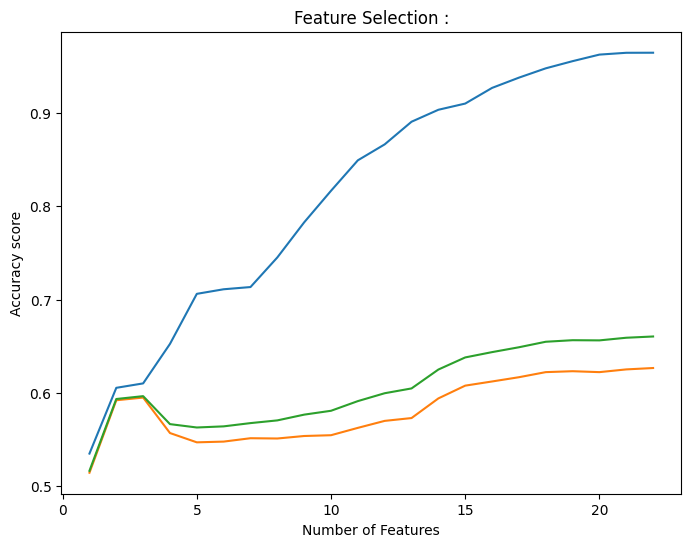

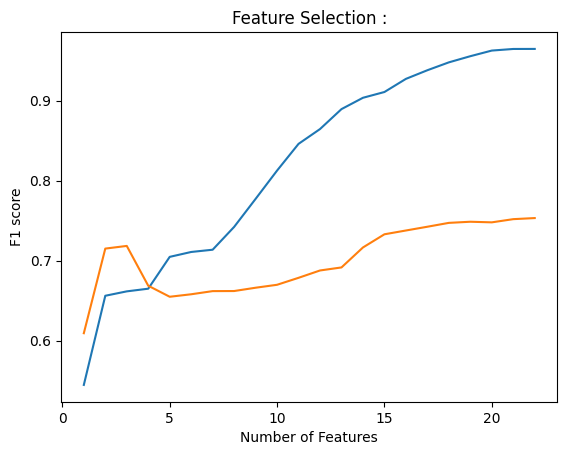

In [56]:
variable = np.arange(1,23)
plt.figure(figsize=(8,6))
plt.title("Feature Selection :")
plt.plot(variable, train_acc.values(), label="Training Accuracy score")
plt.plot(variable, test_acc.values(), label="Testing Accuracy score")
plt.plot(variable, acc_per_features.values(), label="Selection Accuracy score")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy score")
plt.show()
plt.title("Feature Selection :")
plt.plot(variable, train_f1.values(), label="Training F1 score")
plt.plot(variable, test_f1.values(), label="Testing F1 score")
plt.xlabel("Number of Features")
plt.ylabel("F1 score")
plt.show()

In [57]:
print(acc_per_features)
acc_value=[]
for i in range (2,len(sorted_indices)):
  acc_value.append(acc_per_features[i-1])
max_acc_rfc=max(acc_value)
sel_features_rfc=acc_value.index(max_acc_rfc)
print("The number of features which are selected for training the model are ",sel_features_rfc, "which gives an accuracy of ",max_acc_rfc)

{1: 0.5166366374634777, 2: 0.5935351477127874, 3: 0.5965943250533158, 4: 0.5666331610551563, 5: 0.5630338698988901, 6: 0.5642373850117839, 7: 0.5677291944127031, 8: 0.5706347640313503, 9: 0.5767998838017414, 10: 0.5809373070246371, 11: 0.591288398730172, 12: 0.5997281153995362, 13: 0.6048714586630979, 14: 0.6250982872684148, 15: 0.6380662828496229, 16: 0.6437556776814028, 17: 0.6489546996519617, 18: 0.6548570285031725, 19: 0.6565165186296124, 20: 0.6563277947542318, 21: 0.6591523776021715, 22: 0.6604965486349494}
The number of features which are selected for training the model are  21 which gives an accuracy of  0.6604965486349494


In [58]:
if (max_acc_chi > max_acc_rfc):
  sel_five_cols=SelectKBest(chi2, k=sel_features_chi)
  sel_five_cols.fit(train_X_corr,train_Y_SMOTE)
  train_X_sel=train_X_corr[train_X_corr.columns[sel_five_cols.get_support()]]
  val_X_sel=val_X_corr[val_X_corr.columns[sel_five_cols.get_support()]]
  test_X_sel=test_X_corr[test_X_corr.columns[sel_five_cols.get_support()]]
  print("Number of features : ",sel_features_chi)
else:
  train_X_sel=train_X_corr.iloc[:, sorted_indices[0:sel_features_rfc]]
  val_X_sel=val_X_corr.iloc[:, sorted_indices[0:sel_features_rfc]]
  test_X_sel=test_X_corr.iloc[:, sorted_indices[0:sel_features_rfc]]
  print("Number of features : ",sel_features_rfc)

Number of features :  16


In [59]:
print(train_X_sel.columns)
train_Y=train_Y_SMOTE

Index(['no_guests', 'room_category_1', 'room_category_2', 'room_category_3',
       'room_category_4', 'property_name_1', 'property_name_2',
       'property_name_3', 'property_name_4', 'property_name_5',
       'property_name_6', 'city_1', 'city_2', 'city_3', 'city_4',
       'no_days_checkin_checkout'],
      dtype='object')


In [60]:
sel_feat=list(train_X_sel.columns)

In [61]:
f = open("selected_features.txt", "w")
f.write(str(list(train_X_sel.columns)))
f.close()

In [62]:
scaler=StandardScaler()
train_X=scaler.fit_transform(train_X_sel)
val_X=scaler.transform(val_X_sel)
test_X=scaler.transform(test_X_sel)

In [63]:
train_X

array([[ 0.02591063,  2.00798839, -0.72245476, ..., -0.51701446,
        -0.56383659, -0.19103966],
       [-0.97402034, -0.49801085,  1.38416971, ..., -0.51701446,
        -0.56383659, -0.7710525 ],
       [ 0.02591063, -0.49801085,  1.38416971, ...,  1.93418189,
        -0.56383659,  0.38897317],
       ...,
       [ 0.02591063, -0.49801085, -0.72245476, ..., -0.51701446,
        -0.56383659, -0.7710525 ],
       [ 0.02591063, -0.49801085,  1.38416971, ..., -0.51701446,
        -0.56383659, -0.7710525 ],
       [-0.97402034, -0.49801085, -0.72245476, ...,  1.93418189,
        -0.56383659,  0.38897317]])

<h3> Choosing the Model for Classification Model </h1>

In [64]:
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,mean_absolute_error
dtc=DecisionTreeClassifier(random_state=0)

In [65]:
def model_analyze(model):
    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    pred_train_Y = model.predict(train_X)
    print("\n--------------------Training Set--------------------\n")
    print(classification_report(train_Y,pred_train_Y))
    print("\n----------------------Test Set----------------------\n")
    print(classification_report(test_Y, pred_Y))
    ConfusionMatrixDisplay.from_estimator(model,test_X,test_Y,colorbar=True)
    plt.title(" Confusion Matrix")
    plt.show()
    model_train_auc = roc_auc_score(train_Y, pred_train_Y)
    print('AUC: %.3f' % model_train_auc)
    model_train_fpr, model_train_tpr, model_train_thresholds = roc_curve(train_Y, pred_train_Y)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(model_train_fpr, model_train_tpr)
    plt.title(" ROC Curve for Train Data ")
    plt.show()
    model_test_auc = roc_auc_score(test_Y, pred_Y)
    print('AUC: %.3f' % model_test_auc)
    model_train_fpr, model_train_tpr, model_train_thresholds = roc_curve(test_Y, pred_Y)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(model_train_fpr, model_train_tpr)
    plt.title(" ROC Curve for Test Data ")

0.786357159491362

--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.83      0.50      0.63     66088
           1       0.64      0.90      0.75     66088

    accuracy                           0.70    132176
   macro avg       0.74      0.70      0.69    132176
weighted avg       0.74      0.70      0.69    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.12      0.17      6027
           1       0.70      0.88      0.78     14162

    accuracy                           0.65     20189
   macro avg       0.50      0.50      0.47     20189
weighted avg       0.58      0.65      0.60     20189



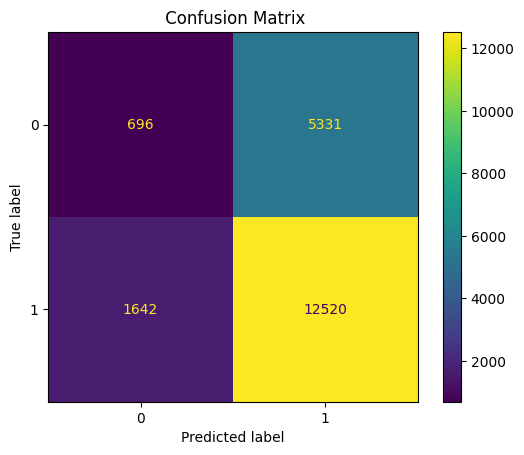

AUC: 0.702


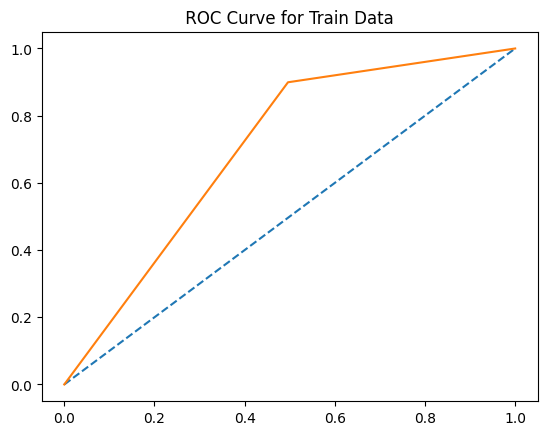

AUC: 0.500


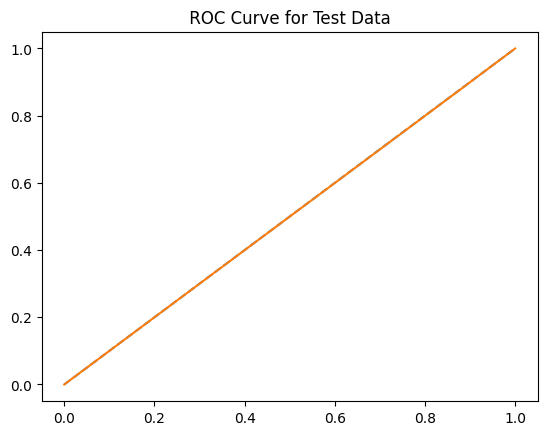

In [66]:
kf = KFold(n_splits=5, random_state=None)
result = cross_val_score(dtc, val_X, val_Y, cv=kf, scoring='f1')
print(result.mean())
model_analyze(dtc)

C:\Users\donku\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.84      0.50      0.63     66088
           1       0.64      0.90      0.75     66088

    accuracy                           0.70    132176
   macro avg       0.74      0.70      0.69    132176
weighted avg       0.74      0.70      0.69    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.11      0.16      6027
           1       0.70      0.89      0.78     14162

    accuracy                           0.66     20189
   macro avg       0.50      0.50      0.47     20189
weighted avg       0.58      0.66      0.60     20189



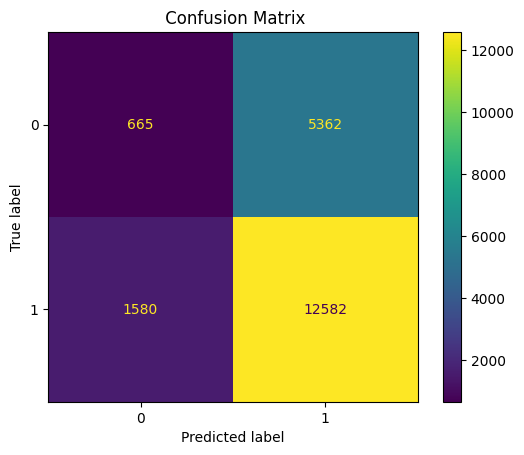

AUC: 0.702


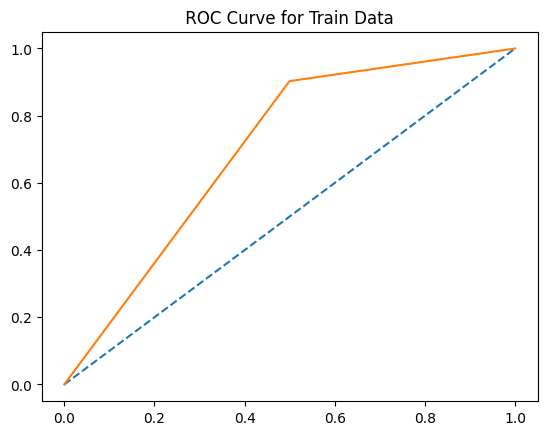

AUC: 0.499


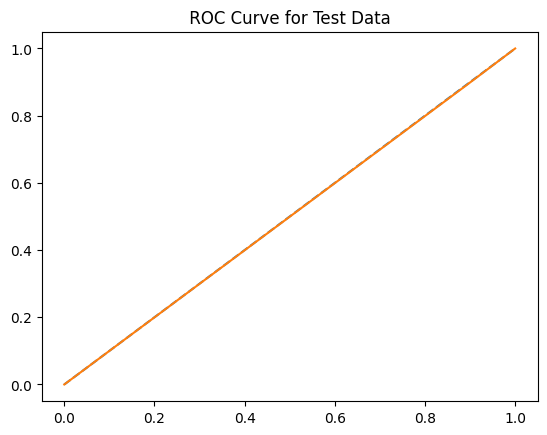

In [67]:
ada=AdaBoostClassifier(estimator=dtc)
model_analyze(ada)


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.84      0.50      0.63     66088
           1       0.64      0.90      0.75     66088

    accuracy                           0.70    132176
   macro avg       0.74      0.70      0.69    132176
weighted avg       0.74      0.70      0.69    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.29      0.11      0.16      6027
           1       0.70      0.89      0.78     14162

    accuracy                           0.66     20189
   macro avg       0.50      0.50      0.47     20189
weighted avg       0.58      0.66      0.60     20189



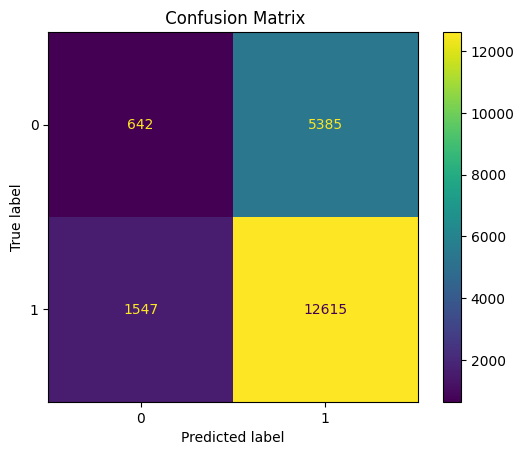

AUC: 0.702


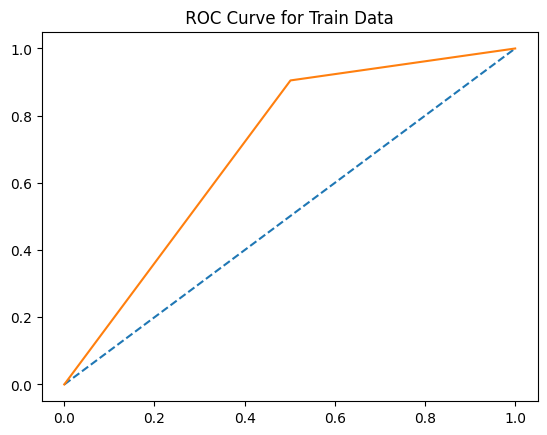

AUC: 0.499


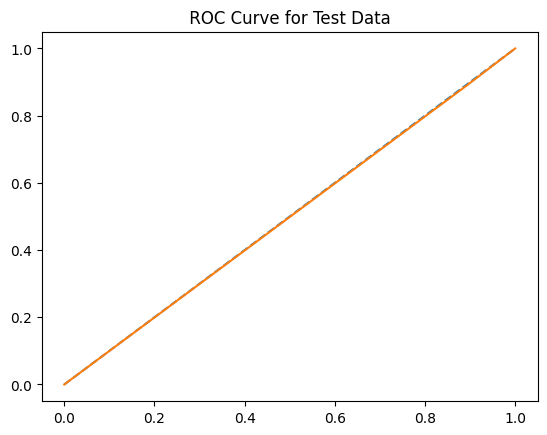

In [68]:
rdc=RandomForestClassifier(random_state=0, n_jobs=-1)
model_analyze(rdc)


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.86      0.44      0.58     66088
           1       0.62      0.93      0.75     66088

    accuracy                           0.68    132176
   macro avg       0.74      0.68      0.66    132176
weighted avg       0.74      0.68      0.66    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.07      0.12      6027
           1       0.70      0.93      0.80     14162

    accuracy                           0.67     20189
   macro avg       0.50      0.50      0.46     20189
weighted avg       0.58      0.67      0.60     20189



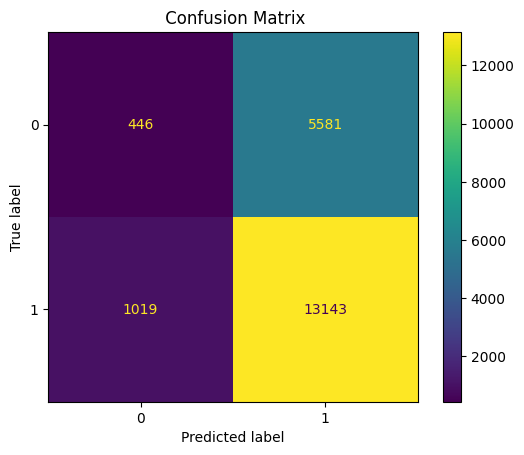

AUC: 0.683


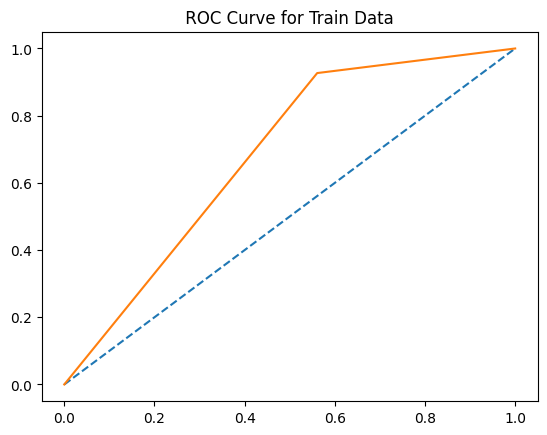

AUC: 0.501


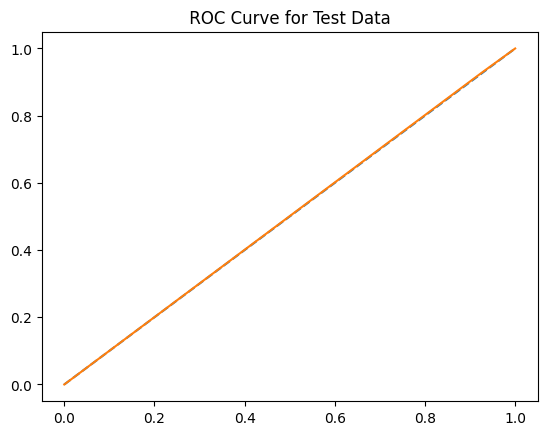

In [69]:
gb = GradientBoostingClassifier()
model_analyze(gb)


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.85      0.48      0.62     66088
           1       0.64      0.91      0.75     66088

    accuracy                           0.70    132176
   macro avg       0.74      0.70      0.68    132176
weighted avg       0.74      0.70      0.68    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.09      0.14      6027
           1       0.70      0.91      0.79     14162

    accuracy                           0.66     20189
   macro avg       0.50      0.50      0.47     20189
weighted avg       0.58      0.66      0.60     20189



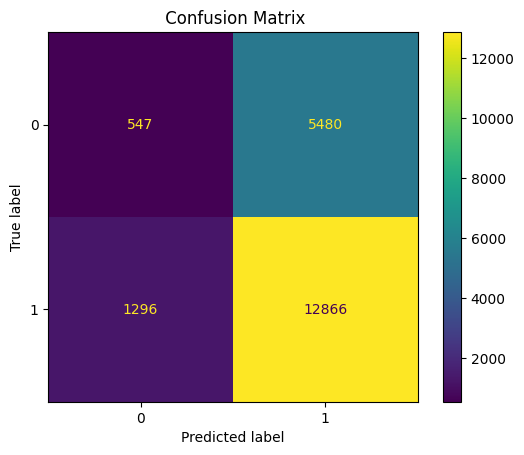

AUC: 0.698


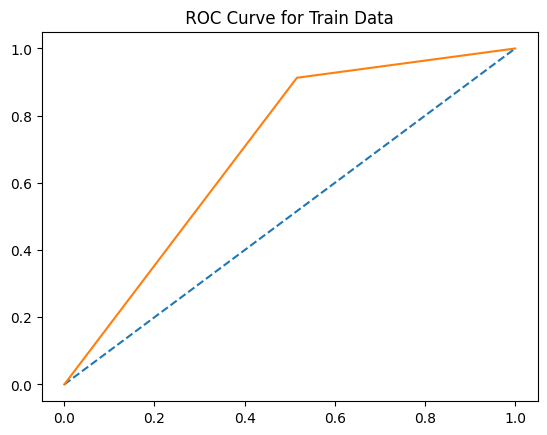

AUC: 0.500


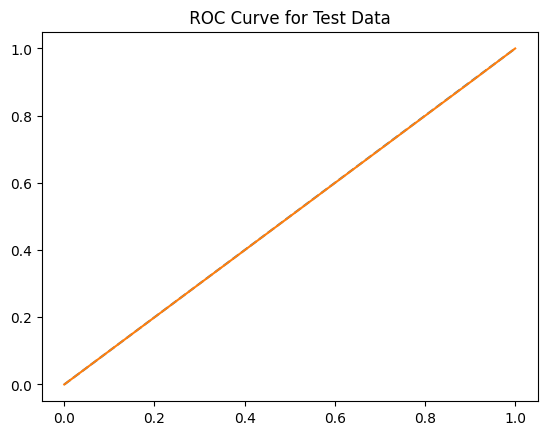

In [70]:
xgb = XGBClassifier(eval_metric='logloss', random_state=0)
model_analyze(xgb)


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.72      0.50      0.59     66088
           1       0.62      0.80      0.70     66088

    accuracy                           0.65    132176
   macro avg       0.67      0.65      0.64    132176
weighted avg       0.67      0.65      0.64    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.21      0.25      6027
           1       0.70      0.79      0.74     14162

    accuracy                           0.62     20189
   macro avg       0.50      0.50      0.49     20189
weighted avg       0.58      0.62      0.59     20189



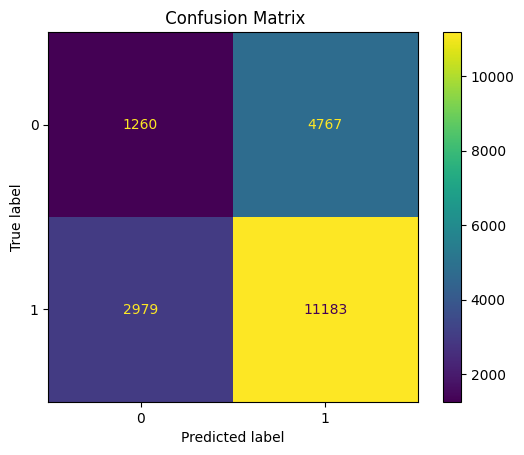

AUC: 0.652


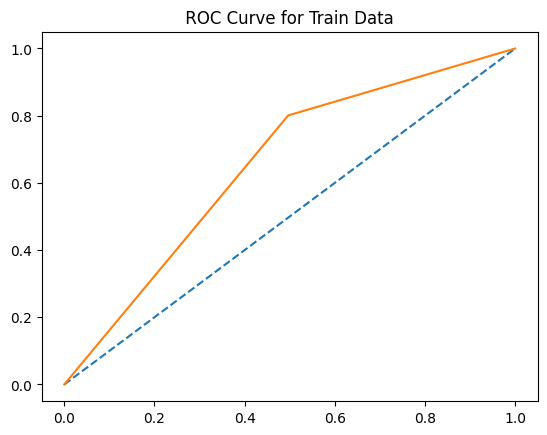

AUC: 0.499


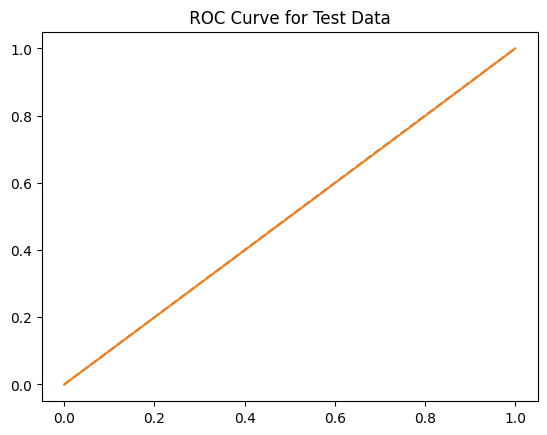

In [71]:
#kNN Nearest Neighbour
knn_model = KNeighborsClassifier(n_neighbors=3)
model_analyze(knn_model)


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.78      0.53      0.63     66088
           1       0.64      0.86      0.73     66088

    accuracy                           0.69    132176
   macro avg       0.71      0.69      0.68    132176
weighted avg       0.71      0.69      0.68    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.14      0.19      6027
           1       0.70      0.85      0.77     14162

    accuracy                           0.64     20189
   macro avg       0.50      0.50      0.48     20189
weighted avg       0.58      0.64      0.60     20189



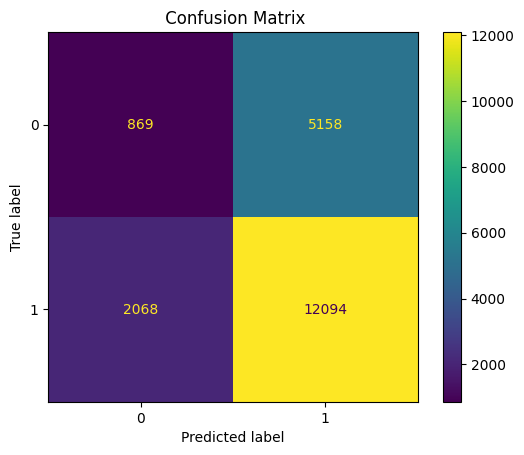

AUC: 0.691


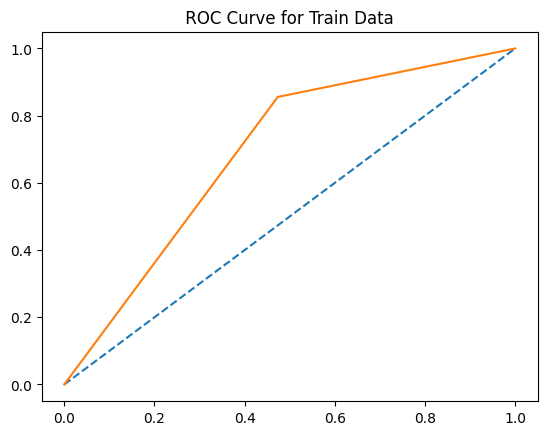

AUC: 0.499


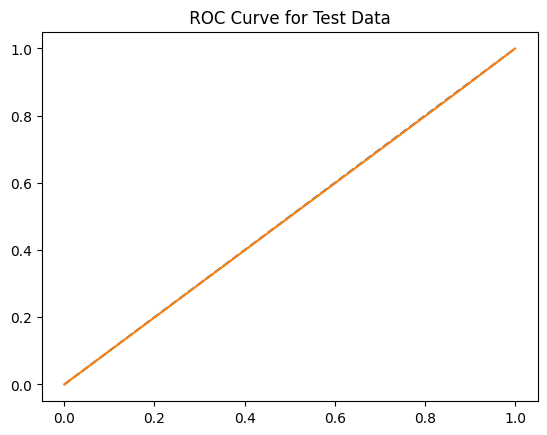

In [72]:
#Logistic Regression
log_model = LogisticRegression(class_weight="balanced")
model_analyze(log_model)


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.58      0.72      0.65     66088
           1       0.64      0.49      0.55     66088

    accuracy                           0.60    132176
   macro avg       0.61      0.60      0.60    132176
weighted avg       0.61      0.60      0.60    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.52      0.38      6027
           1       0.70      0.49      0.58     14162

    accuracy                           0.50     20189
   macro avg       0.50      0.50      0.48     20189
weighted avg       0.58      0.50      0.52     20189



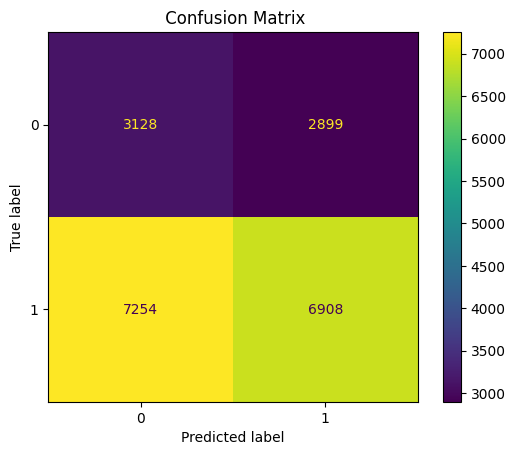

AUC: 0.604


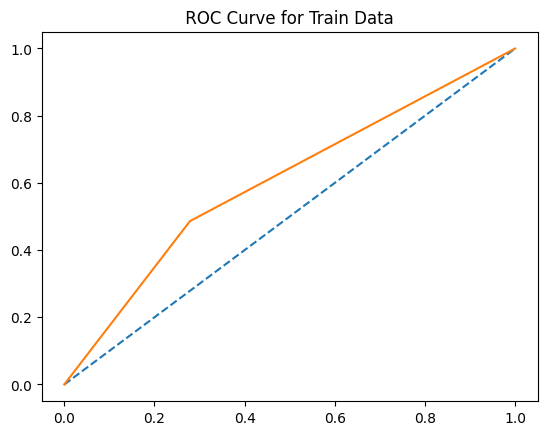

AUC: 0.503


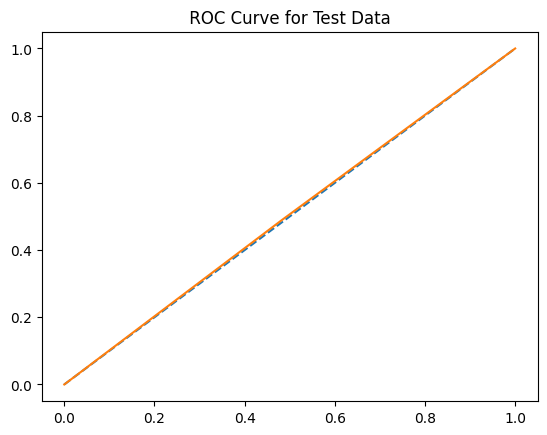

In [73]:
#Gaussian Naive Bayes
nb_model = GaussianNB()
model_analyze(nb_model)

Hyper Parameter Tuning for Random Forest
Classifier

In [74]:
auc=[]
def rfc_objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 32)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Create and fit random forest model
    model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
    )

    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    kf = KFold(n_splits=5, random_state=None)
    result = cross_val_score(model, val_X, val_Y, cv=kf, scoring='f1')
    print(result.mean())
    mae = mean_absolute_error(test_Y, pred_Y)
    # Return MAE
    return mae

In [75]:
study = optuna.create_study(direction="minimize")
study.optimize(rfc_objective, n_trials=50, show_progress_bar=True)
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

[I 2024-06-19 13:10:38,934] A new study created in memory with name: no-name-3eeae1db-1a2b-48c4-bc74-5e7426645c97


  0%|          | 0/50 [00:00<?, ?it/s]

0.8244778204363019
[I 2024-06-19 13:10:39,519] Trial 0 finished with value: 0.44425182029818217 and parameters: {'n_estimators': 11, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.44425182029818217.
0.8221041085372981
[I 2024-06-19 13:10:51,300] Trial 1 finished with value: 0.3388478874634702 and parameters: {'n_estimators': 130, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.3388478874634702.
0.799999836276337
[I 2024-06-19 13:10:52,964] Trial 2 finished with value: 0.3440487394125514 and parameters: {'n_estimators': 17, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.3388478874634702.
0.8208339420255036
[I 2024-06-19 13:13:35,918] Trial 3 finished with value: 0.3388478874634702 and parameters: {'n_estimators': 109, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.3388478874634702.
0.8152632762586816


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.86      0.44      0.58     66088
           1       0.62      0.93      0.75     66088

    accuracy                           0.69    132176
   macro avg       0.74      0.69      0.67    132176
weighted avg       0.74      0.69      0.67    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.07      0.12      6027
           1       0.70      0.93      0.80     14162

    accuracy                           0.67     20189
   macro avg       0.50      0.50      0.46     20189
weighted avg       0.58      0.67      0.60     20189



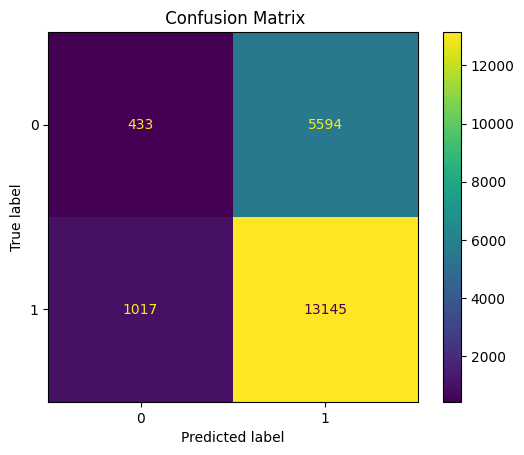

AUC: 0.685


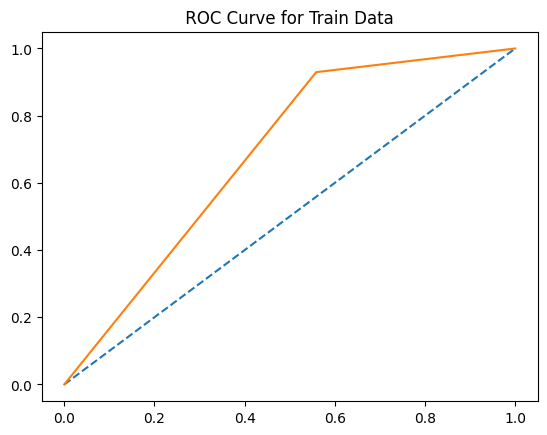

AUC: 0.500


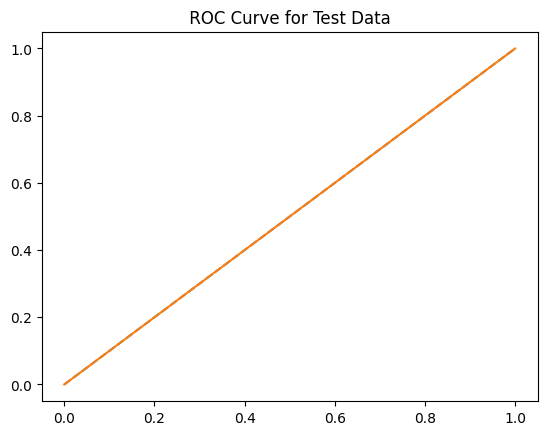

In [76]:
rfc=RandomForestClassifier(**study.best_params)
model_analyze(rfc)
pred_Y = rfc.predict(test_X)
auc.append(accuracy_score(test_Y, pred_Y))

Hyper Parameter Tuning for KNN

In [77]:
def knn_objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    kf = KFold(n_splits=5, random_state=None)
    result = cross_val_score(model, val_X, val_Y, cv=kf, scoring='f1')
    print(result.mean())
    mae = mean_absolute_error(test_Y, pred_Y)
    # Return MAE
    return mae

In [78]:
study = optuna.create_study(direction="minimize")
study.optimize(knn_objective, n_trials=50, show_progress_bar=True)
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

[I 2024-06-19 13:15:49,445] A new study created in memory with name: no-name-2db0d622-d5d8-49cf-b58e-b7e9da444963


  0%|          | 0/50 [00:00<?, ?it/s]

0.7962039951799998
[I 2024-06-19 13:15:54,627] Trial 0 finished with value: 0.32433503392936747 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.32433503392936747.
0.7896099301974384
[I 2024-06-19 13:16:08,124] Trial 1 finished with value: 0.32522660854921 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.32433503392936747.
0.8123665677156076
[I 2024-06-19 13:16:21,648] Trial 2 finished with value: 0.3153202238842934 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 2 with value: 0.3153202238842934.
0.5727134894985029
[I 2024-06-19 13:16:26,905] Trial 3 finished with value: 0.49626033978899403 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.3153202238842934.
0.6768909295877978
[I 2024-06-19 13:16:31,530] Trial 4 finished with value: 0.438456585269206 and pa


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.96      0.38      0.55     66088
           1       0.62      0.99      0.76     66088

    accuracy                           0.68    132176
   macro avg       0.79      0.68      0.65    132176
weighted avg       0.79      0.68      0.65    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.32      0.02      0.04      6027
           1       0.70      0.98      0.82     14162

    accuracy                           0.69     20189
   macro avg       0.51      0.50      0.43     20189
weighted avg       0.59      0.69      0.59     20189



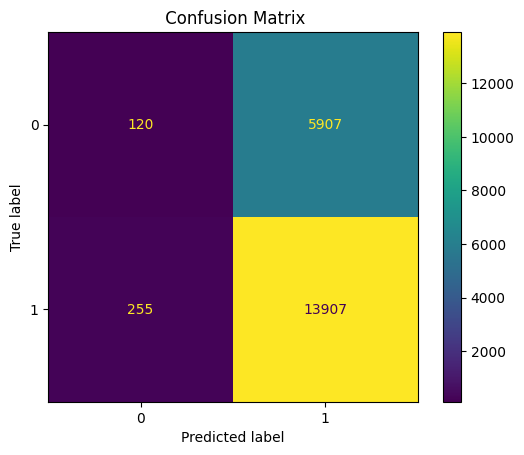

AUC: 0.685


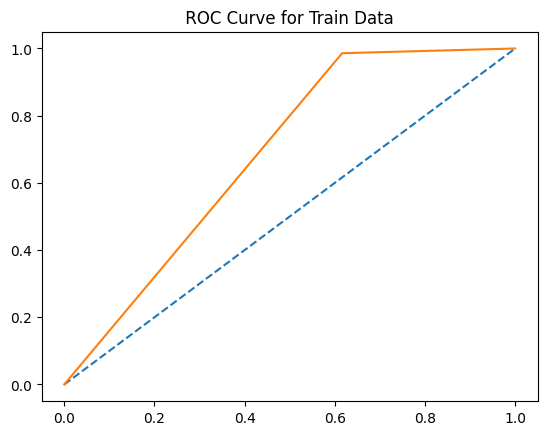

AUC: 0.501


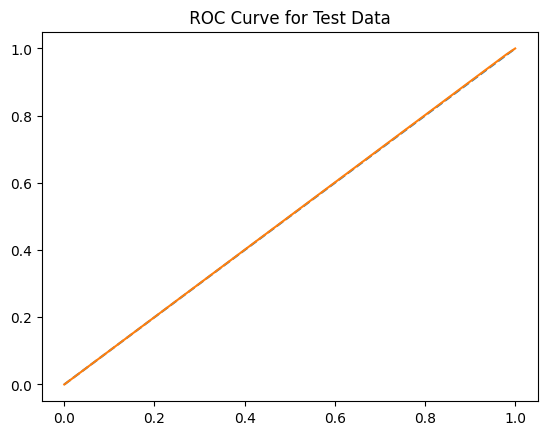

In [79]:
knn=KNeighborsClassifier(**study.best_params)
model_analyze(knn)
pred_Y = knn.predict(test_X)
auc.append(accuracy_score(test_Y, pred_Y))

Hyper Parameter Tuning for Logistic Regression

In [80]:
def log_objective(trial):
    tol= trial.suggest_float('tol' , 1e-6 , 1e-3)
    C = trial.suggest_float("C", 1e-2, 1)
    fit_intercept = trial.suggest_categorical('fit_intercept' , [True, False])
    random_state = trial.suggest_categorical('random_state' , [0, 42, 2021, 555])
    solver = trial.suggest_categorical('solver' , ['lbfgs','liblinear'])
    model = LogisticRegression(tol=tol, C=C, fit_intercept = fit_intercept, random_state=random_state, solver=solver)
    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    model.fit(train_X,train_Y)
    pred_Y = model.predict(test_X)
    kf = KFold(n_splits=5, random_state=None)
    result = cross_val_score(model, val_X, val_Y, cv=kf, scoring='f1')
    print(result.mean())
    mae = mean_absolute_error(test_Y, pred_Y)
    # Return MAE
    return mae

In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(log_objective, n_trials=50, show_progress_bar=True)
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

[I 2024-06-19 13:22:07,004] A new study created in memory with name: no-name-31ac31ee-5ccb-4ae0-8e55-507a99415625


  0%|          | 0/50 [00:00<?, ?it/s]

0.8244778204363019
[I 2024-06-19 13:22:07,723] Trial 0 finished with value: 0.30813809500222894 and parameters: {'tol': 0.00012820171575129988, 'C': 0.4215800602792523, 'fit_intercept': False, 'random_state': 555, 'solver': 'liblinear'}. Best is trial 0 with value: 0.30813809500222894.
0.8244778204363019
[I 2024-06-19 13:22:08,668] Trial 1 finished with value: 0.35791767794343454 and parameters: {'tol': 0.0007827859037065476, 'C': 0.6661389128112947, 'fit_intercept': True, 'random_state': 2021, 'solver': 'liblinear'}. Best is trial 1 with value: 0.35791767794343454.
0.8244778204363019
[I 2024-06-19 13:22:09,627] Trial 2 finished with value: 0.35791767794343454 and parameters: {'tol': 0.0008503516140171732, 'C': 0.6874214655995496, 'fit_intercept': True, 'random_state': 42, 'solver': 'liblinear'}. Best is trial 1 with value: 0.35791767794343454.
0.8244778204363019
[I 2024-06-19 13:22:09,792] Trial 3 finished with value: 0.30858388231215017 and parameters: {'tol': 0.000906522059825346, '


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.78      0.53      0.63     66088
           1       0.64      0.85      0.73     66088

    accuracy                           0.69    132176
   macro avg       0.71      0.69      0.68    132176
weighted avg       0.71      0.69      0.68    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.15      0.20      6027
           1       0.70      0.85      0.77     14162

    accuracy                           0.64     20189
   macro avg       0.50      0.50      0.48     20189
weighted avg       0.58      0.64      0.60     20189



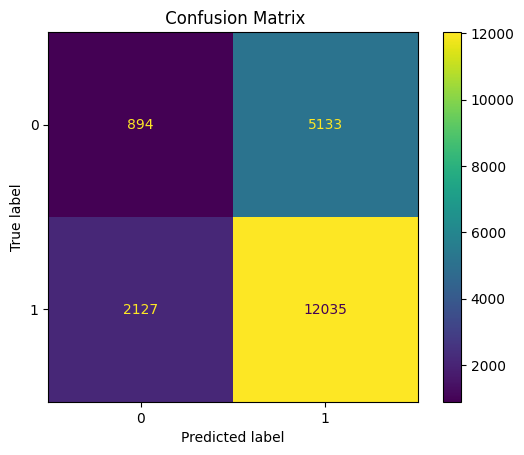

AUC: 0.691


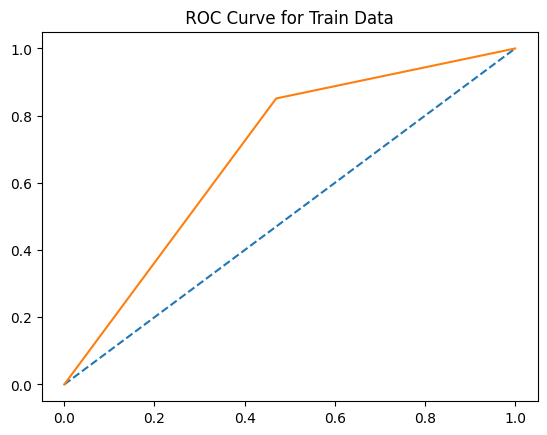

AUC: 0.499


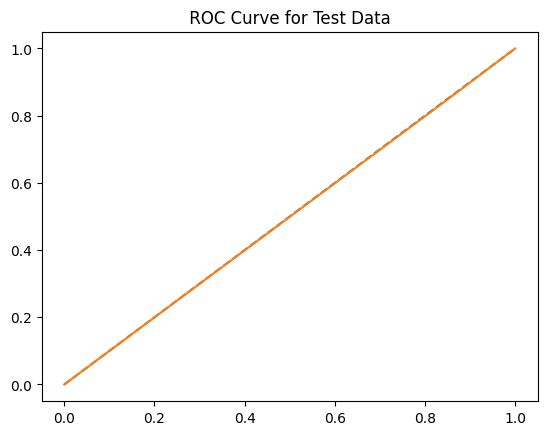

In [82]:
log=LogisticRegression(**study.best_params)
model_analyze(log)
pred_Y = log.predict(test_X)
auc.append(accuracy_score(test_Y, pred_Y))


--------------------Training Set--------------------

              precision    recall  f1-score   support

           0       0.58      0.72      0.65     66088
           1       0.64      0.49      0.55     66088

    accuracy                           0.60    132176
   macro avg       0.61      0.60      0.60    132176
weighted avg       0.61      0.60      0.60    132176


----------------------Test Set----------------------

              precision    recall  f1-score   support

           0       0.30      0.52      0.38      6027
           1       0.70      0.49      0.58     14162

    accuracy                           0.50     20189
   macro avg       0.50      0.50      0.48     20189
weighted avg       0.58      0.50      0.52     20189



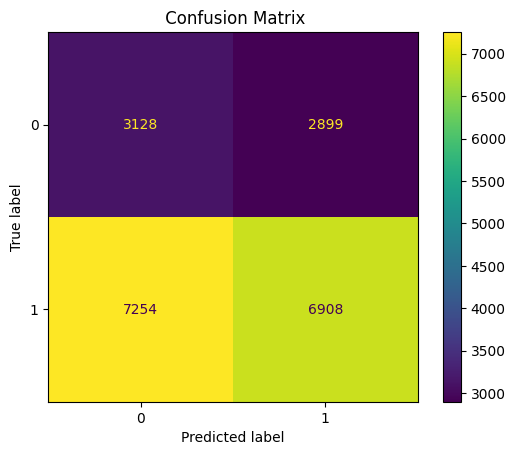

AUC: 0.604


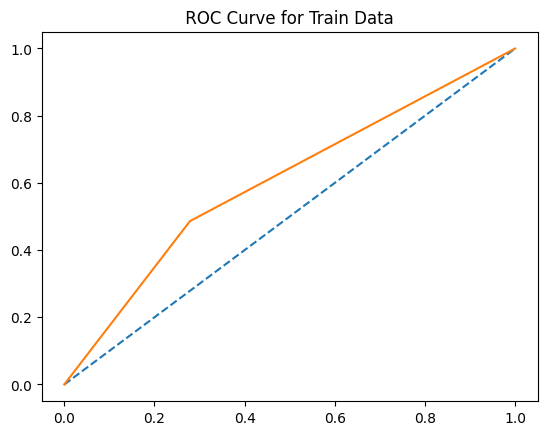

AUC: 0.503


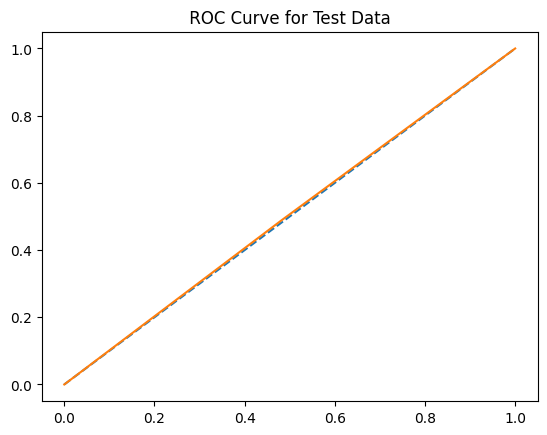

In [83]:
nb=GaussianNB()
model_analyze(nb)
pred_Y = nb.predict(test_X)
auc.append(accuracy_score(test_Y, pred_Y))

In [84]:
auc

[0.6725444549011839,
 0.6947842884739215,
 0.6403982366635297,
 0.4971023824855119]

In [85]:
max_auc=max(auc)
high_auc=auc.index(max_auc)

In [86]:
auc.index(max_auc)

1

In [87]:
if high_auc==0:
  pickle.dump(rfc, open('model.pkl','wb'))
elif high_auc==1:
  pickle.dump(knn, open('model.pkl','wb'))
elif high_auc==2:
  pickle.dump(log, open('model.pkl','wb'))
elif high_auc==3:
  pickle.dump(nb, open('model.pkl','wb'))

In [88]:
pickle.dump(encoder, open('encoder.obj','wb'))
pickle.dump(scaler, open('scaler.obj','wb'))